[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NorisTalaban/LLmini/blob/main/320_5_9.ipynb)

In [1]:
import os
import math
import time
import json
import shutil
import random
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import GPT2Tokenizer
from datasets import load_dataset
from google.colab import files
import psutil
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

In [2]:
start_time = time.time()

In [3]:
# ------HYPERPARAMETERS & CONFIGURATION-------

BLOCK_SIZE = 256
BATCH_SIZE = 32
MAX_SAMPLES_PER_DATASET = 20_000
DEFAULT_FRAC = 1
numEpochs = 3

SEED = 42 # Random seed for reproducibility

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
vocab_size = tokenizer.vocab_size

print(f"\n{'='*100}")
print("CONFIGURATION")
print(f"{'='*100}")
print(f"Block size: {BLOCK_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Default fraction: {DEFAULT_FRAC}")
print(f"Number of epochs: {numEpochs}")
print(f"Device: {device}")
print(f"Seed: {SEED}")
print(f"{'='*100}\n")



datasets_info = {
    "gsm8k": ("main", None, DEFAULT_FRAC * 2.7),
    "allenai/ai2_arc": ("ARC-Challenge", None, DEFAULT_FRAC * 17.0),
    "commonsense_qa": (None, None, DEFAULT_FRAC * 2.0),
    "sciq": (None, None, DEFAULT_FRAC * 1.7),
    "boolq": (None, None, DEFAULT_FRAC * 2.1),
    "hellaswag": (None, None, DEFAULT_FRAC * 0.5),
    "winogrande": ("winogrande_xl", None, DEFAULT_FRAC * 0.5),
    "ag_news": (None, None, DEFAULT_FRAC * 0.17),
    "squad": (None, None, DEFAULT_FRAC * 0.23),
    "wikitext": ("wikitext-2-raw-v1", None, DEFAULT_FRAC * 0.54),
    "roneneldan/TinyStories": (None, None, DEFAULT_FRAC * 0.009),
}

#text extraction function

def extract_text_from_sample(sample, dataset_name):
    if dataset_name == "squad":
        text = sample.get("context", "")
    elif dataset_name == "wikitext":
        text = sample.get("text", "")
    elif dataset_name == "roneneldan/TinyStories":
        text = sample.get("text", "")
    elif dataset_name == "hellaswag":
        text = sample.get("ctx", "")
    elif dataset_name == "winogrande":
        text = sample.get("sentence", "")
    elif dataset_name == "commonsense_qa":
        text = sample.get("question", "")
    elif dataset_name == "gsm8k":
        text = sample.get("question", "")
    elif dataset_name == "ag_news":
        text = sample.get("text", "")
    elif dataset_name == "boolq":
        passage = sample.get("passage", "")
        question = sample.get("question", "")
        text = f"{passage} {question}"
    elif dataset_name == "sciq":
        question = sample.get("question", "")
        support = sample.get("support", "")
        text = f"{question} {support}"
    elif dataset_name == "allenai/ai2_arc":
        text = sample.get("question", "")
    elif dataset_name == "super_glue":
        premise = sample.get("premise", "")
        hypothesis = sample.get("hypothesis", "")
        text = f"{premise} {hypothesis}"
    else:
        text = sample.get("text", sample.get("caption", ""))

    return text.strip()

print(f"\n{'='*100}")
print("STARTING DATA COLLECTION")
print(f"{'='*100}\n")

text_subset = []
dataset_origins = []
dataset_collection_stats = {}

# Iterate through each dataset and collect samples
for name, info in datasets_info.items():
    if isinstance(info, tuple):
        if len(info) == 3:
            config, lang, frac = info
        elif len(info) == 2:
            config, frac = info
            lang = None
        else:
            config, lang, frac = info[0], None, DEFAULT_FRAC
    else:
        config, lang, frac = info, None, DEFAULT_FRAC

    frac = DEFAULT_FRAC if frac is None else frac

    print(f"{'─'*100}")
    print(f"Dataset: {name}")
    print(f"{'─'*100}")
  # Load dataset
    try:
        ds = load_dataset(name, lang, split="train") if lang else load_dataset(name, config, split="train")
        print(f"Loaded | Samples: {len(ds):,}")
    except Exception as e:
        print(f"Failed: {str(e)}")
        dataset_collection_stats[name] = {
            "status": "failed",
            "error": str(e),
            "collected": 0
        }
        continue

    n_samples = min(int(len(ds) * frac), MAX_SAMPLES_PER_DATASET)
    print(f"Target: {n_samples:,} ({frac*100:.2f}%)")

    count = 0
    skipped_empty = 0
    skipped_length = 0

    for sample in tqdm(ds, total=n_samples, desc="Collecting", leave=False):
        text = extract_text_from_sample(sample, name)

        if not text:
            skipped_empty += 1
            continue

        if not (10 < len(text) < BLOCK_SIZE * 10):
            skipped_length += 1
            continue

        text_subset.append(text)
        dataset_origins.append(name)
        count += 1

        if count >= n_samples:
            break

    dataset_collection_stats[name] = {
        "status": "success",
        "total_size": len(ds),
        "target_samples": n_samples,
        "collected": count,
        "fraction": frac,
        "skipped_empty": skipped_empty,
        "skipped_length": skipped_length,
        "success_rate": (count / n_samples * 100) if n_samples > 0 else 0
    }

    print(f"Collected: {count:,}")
    if skipped_empty > 0:
        print(f"  Skipped (empty): {skipped_empty:,}")
    if skipped_length > 0:
        print(f"  Skipped (length): {skipped_length:,}")
    print()

print(f"\n{'='*100}")
print("DATA COLLECTION VERIFICATION")
print(f"{'='*100}\n")

total_collected = len(text_subset)
total_tracked = len(dataset_origins)

print(f"Total texts collected: {total_collected:,}")
print(f"Total datasets tracked: {total_tracked:,}")

if total_collected == total_tracked:
    print("VERIFICATION PASSED")
else:
    print("VERIFICATION FAILED")

print(f"\n{'─'*100}")
print("REPRODUCIBILITY CHECK")
print(f"{'─'*100}")
print(f"Seed: {SEED}")
print("Python random: seeded")
print("NumPy random: seeded")
print("PyTorch CPU: seeded")
print("PyTorch GPU: seeded")
print("CuDNN: deterministic mode ON")
print("DataLoader: generator with seed + num_workers=0")
print("random_split: generator with seed")

print(f"\n{'─'*100}")
print("COLLECTION SUMMARY BY DATASET")
print(f"{'─'*100}\n")

dataset_summary = defaultdict(int)
for dataset_name in dataset_origins:
    dataset_summary[dataset_name] += 1

print(f"{'Dataset':<35} {'Count':>12} {'% of Total':>12}")
print(f"{'─'*100}")
for dataset_name in sorted(dataset_summary.keys()):
    count = dataset_summary[dataset_name]
    pct = (count / total_collected * 100) if total_collected > 0 else 0
    print(f"{dataset_name:<35} {count:>12,} {pct:>11.1f}%")
print(f"{'─'*100}")
print(f"{'TOTAL':<35} {total_collected:>12,} {100.0:>11.1f}%")
print()

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, block_size):
        self.examples = []
        self.stride = block_size // 2
        self.block_size = block_size
        self.padded_count = 0
        self.chunked_count = 0

        for t in texts:
            tokens = tokenizer.encode(t)

            if len(tokens) < block_size + 1:
                tokens += [tokenizer.pad_token_id] * (block_size + 1 - len(tokens))
                self.examples.append(tokens[:block_size + 1])
                self.padded_count += 1
            else:
                for i in range(0, len(tokens), self.stride):
                    if i + block_size + 1 <= len(tokens):
                        self.examples.append(tokens[i:i + block_size + 1])
                self.chunked_count += 1

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        tokens = self.examples[idx]
        return (
            torch.tensor(tokens[:-1], dtype=torch.long),
            torch.tensor(tokens[1:], dtype=torch.long),
        )

print(f"\n{'='*100}")
print("CREATING DATASETS AND DATALOADERS")
print(f"{'='*100}\n")

full_dataset = TextDataset(text_subset, tokenizer, BLOCK_SIZE)
print(f"Full dataset created")
print(f"  Total chunks: {len(full_dataset):,}")
print(f"  Padded texts: {full_dataset.padded_count:,}")
print(f"  Chunked texts: {full_dataset.chunked_count:,}")

val_size = int(0.05 * len(full_dataset))

g = torch.Generator()
g.manual_seed(SEED)

train_dataset, val_dataset = random_split(
    full_dataset,
    [len(full_dataset) - val_size, val_size],
    generator=g
)
print(f"\nTrain/val split created")
print(f"  Train: {len(train_dataset):,} chunks")
print(f"  Val: {len(val_dataset):,} chunks")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=g,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    generator=g
)
print(f"\nDataloaders created")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches: {len(val_loader):,}")

print(f"\n{'='*100}")
print("COMPUTING STATISTICS FOR ANALYSIS")
print(f"{'='*100}\n")

raw_token_lengths = [len(tokenizer.encode(t)) for t in text_subset]
total_raw_tokens = sum(raw_token_lengths)

print(f"Token statistics computed")
print(f"  Total raw tokens: {total_raw_tokens:,}")
print(f"  Unique texts: {len(text_subset):,}")

dataset_metrics = {
    "text_subset": text_subset,
    "dataset_origins": dataset_origins,
    "raw_token_lengths": raw_token_lengths,
    "total_raw_tokens": total_raw_tokens,
    "vocab_size": vocab_size,
    "block_size": BLOCK_SIZE,
    "batch_size": BATCH_SIZE,
    "numEpochs": numEpochs,
    "train_size": len(train_dataset),
    "val_size": len(val_dataset),
    "train_batches": len(train_loader),
    "val_batches": len(val_loader),
    "total_examples": len(full_dataset),
    "padded_texts": full_dataset.padded_count,
    "chunked_texts": full_dataset.chunked_count,
    "stride": full_dataset.stride,
    "collection_stats": dataset_collection_stats,
    "seed": SEED,
}

print(f"\n{'='*100}")
print("DATA COLLECTION COMPLETE - READY FOR TRAINING")
print(f"{'='*100}\n")

print(f"text_subset:     {len(text_subset):>12,} texts")
print(f"dataset_origins: {len(dataset_origins):>12,} labels")
print(f"full_dataset:    {len(full_dataset):>12,} chunks")
print(f"train_dataset:   {len(train_dataset):>12,} chunks")
print(f"val_dataset:     {len(val_dataset):>12,} chunks")
print(f"train_loader:    {len(train_loader):>12,} batches")
print(f"val_loader:      {len(val_loader):>12,} batches")
print(f"dataset_metrics: {len(dataset_metrics):>12,} keys")

print(f"\n{'─'*100}")
print("REPRODUCIBILITY CHECK")
print(f"{'─'*100}")
print(f"Seed: {SEED}")
print("Python random: seeded")
print("NumPy random: seeded")
print("PyTorch CPU: seeded")
print("PyTorch GPU: seeded")
print("CuDNN: deterministic mode ON")
print("DataLoader: generator with seed + num_workers=0")
print("random_split: generator with seed")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


CONFIGURATION
Block size: 256
Batch size: 32
Default fraction: 1
Number of epochs: 3
Device: cuda
Seed: 42


STARTING DATA COLLECTION

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: gsm8k
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Loaded | Samples: 7,473
Target: 20,000 (270.00%)


Collected: 7,473

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: allenai/ai2_arc
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

ARC-Challenge/train-00000-of-00001.parqu(…):   0%|          | 0.00/190k [00:00<?, ?B/s]

ARC-Challenge/test-00000-of-00001.parque(…):   0%|          | 0.00/204k [00:00<?, ?B/s]

ARC-Challenge/validation-00000-of-00001.(…):   0%|          | 0.00/55.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1119 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1172 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/299 [00:00<?, ? examples/s]

Loaded | Samples: 1,119
Target: 19,023 (1700.00%)


Collected: 1,119

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: commonsense_qa
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/160k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Loaded | Samples: 9,741
Target: 19,482 (200.00%)


Collected: 9,741

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: sciq
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.99M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/339k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11679 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loaded | Samples: 11,679
Target: 19,854 (170.00%)


Collected: 11,625
  Skipped (length): 54

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: boolq
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Loaded | Samples: 9,427
Target: 19,796 (210.00%)


Collected: 9,413
  Skipped (length): 14

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: hellaswag
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

Loaded | Samples: 39,905
Target: 19,952 (50.00%)


Collected: 19,952

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: winogrande
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

winogrande_xl/train-00000-of-00001.parqu(…):   0%|          | 0.00/2.06M [00:00<?, ?B/s]

winogrande_xl/test-00000-of-00001.parque(…):   0%|          | 0.00/118k [00:00<?, ?B/s]

winogrande_xl/validation-00000-of-00001.(…):   0%|          | 0.00/85.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40398 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1267 [00:00<?, ? examples/s]

Loaded | Samples: 40,398
Target: 20,000 (50.00%)


Collected: 20,000

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: ag_news
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Loaded | Samples: 120,000
Target: 20,000 (17.00%)


Collected: 20,000

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: squad
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Loaded | Samples: 87,599
Target: 20,000 (23.00%)


Collected: 20,000
  Skipped (length): 5

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: wikitext
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Loaded | Samples: 36,718
Target: 19,827 (54.00%)


Collected: 19,827
  Skipped (empty): 10,965
  Skipped (length): 214

────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset: roneneldan/TinyStories
────────────────────────────────────────────────────────────────────────────────────────────────────


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Loaded | Samples: 2,119,719
Target: 19,077 (0.90%)


Collected: 19,077
  Skipped (length): 148


DATA COLLECTION VERIFICATION

Total texts collected: 158,227
Total datasets tracked: 158,227
VERIFICATION PASSED

────────────────────────────────────────────────────────────────────────────────────────────────────
REPRODUCIBILITY CHECK
────────────────────────────────────────────────────────────────────────────────────────────────────
Seed: 42
Python random: seeded
NumPy random: seeded
PyTorch CPU: seeded
PyTorch GPU: seeded
CuDNN: deterministic mode ON
DataLoader: generator with seed + num_workers=0
random_split: generator with seed

────────────────────────────────────────────────────────────────────────────────────────────────────
COLLECTION SUMMARY BY DATASET
────────────────────────────────────────────────────────────────────────────────────────────────────

Dataset                                    Count   % of Total
────────────────────────────────────────────────────────────────────────────────────────────────────
ag_news           

In [4]:
# DATASET ANALYSIS REPORT

print("\n" + "=" * 100)
print(" " * 30 + "COMPREHENSIVE DATASET ANALYSIS REPORT")
print("=" * 100)

if 'dataset_origins' in locals():
    print("\n" + "─" * 100)
    print("SECTION A: DATASET CONTRIBUTIONS (Token & Sample Breakdown)")
    print("─" * 100)

    # Calculate per-dataset statistics
    dataset_stats = defaultdict(lambda: {
        'samples': 0,
        'total_tokens': 0,
        'token_lengths': [],
    })

    for text, dataset_name in zip(text_subset, dataset_origins):
        tokens = tokenizer.encode(text)
        token_count = len(tokens)

        dataset_stats[dataset_name]['samples'] += 1
        dataset_stats[dataset_name]['total_tokens'] += token_count
        dataset_stats[dataset_name]['token_lengths'].append(token_count)
    # Create results dataframe
    results = []
    for dataset_name in sorted(dataset_stats.keys()):
        data = dataset_stats[dataset_name]
        lengths = np.array(data['token_lengths'])

        results.append({
            'Dataset': dataset_name,
            'Samples': data['samples'],
            'Total Tokens': data['total_tokens'],
            'Avg Tokens': np.mean(lengths),
            'Min Tokens': np.min(lengths),
            'Max Tokens': np.max(lengths),
            'Median Tokens': np.median(lengths),
            'Std Dev': np.std(lengths),
        })

    df_contributions = pd.DataFrame(results)

    total_samples_all = df_contributions['Samples'].sum()
    total_tokens_all = df_contributions['Total Tokens'].sum()

    df_contributions['% Samples'] = (df_contributions['Samples'] / total_samples_all * 100).round(2)
    df_contributions['% Tokens'] = (df_contributions['Total Tokens'] / total_tokens_all * 100).round(2)
    df_contributions = df_contributions.sort_values('Total Tokens', ascending=False).reset_index(drop=True)


    print(f"\n{'─'*100}")
    print("TABLE 1: SAMPLES PER DATASET")
    print(f"{'─'*100}")
    print(f"{'Dataset':<30} {'Samples':>12} {'% Total':>10} {'Avg Tokens':>12} {'Min-Max Range':>25}")
    print(f"{'─'*100}")

    for idx, row in df_contributions.iterrows():
        token_range = f"{int(row['Min Tokens'])}-{int(row['Max Tokens'])}"
        print(f"{row['Dataset']:<30} {int(row['Samples']):>12,} {row['% Samples']:>9.1f}% "
              f"{row['Avg Tokens']:>12.1f} {token_range:>25}")

    print(f"{'─'*100}")
    print(f"{'TOTAL':<30} {int(total_samples_all):>12,} {100.0:>9.1f}%")
    print(f"{'─'*100}")


    print(f"\n{'─'*100}")
    print("TABLE 2: TOKENS PER DATASET")
    print(f"{'─'*100}")
    print(f"{'Dataset':<30} {'Total Tokens':>15} {'% Total':>10} {'Tokens/Sample':>12}")
    print(f"{'─'*100}")

    for idx, row in df_contributions.iterrows():
        tokens_per_sample = row['Total Tokens'] / row['Samples']
        print(f"{row['Dataset']:<30} {int(row['Total Tokens']):>15,} {row['% Tokens']:>9.1f}% "
              f"{tokens_per_sample:>12.1f}")

    print(f"{'─'*100}")
    print(f"{'TOTAL':<30} {int(total_tokens_all):>15,} {100.0:>9.1f}%")
    print(f"{'─'*100}")


    print(f"\n{'─'*100}")
    print("TABLE 3: TOKEN STATISTICS PER DATASET")
    print(f"{'─'*100}")
    print(f"{'Dataset':<30} {'Mean':>10} {'Median':>10} {'Std Dev':>10} {'Min':>10} {'Max':>10}")
    print(f"{'─'*100}")

    for idx, row in df_contributions.iterrows():
        print(f"{row['Dataset']:<30} {row['Avg Tokens']:>10.1f} {row['Median Tokens']:>10.1f} "
              f"{row['Std Dev']:>10.1f} {int(row['Min Tokens']):>10} {int(row['Max Tokens']):>10}")

    print(f"{'─'*100}")


    print(f"\n{'─'*100}")
    print("KEY INSIGHTS - DATASET BALANCE")   # Key insights about dataset balance
    print(f"{'─'*100}")

    most_samples_idx = df_contributions['Samples'].idxmax()
    most_samples = df_contributions.loc[most_samples_idx]
    print(f"Most samples: {most_samples['Dataset']:<30} {int(most_samples['Samples']):>10,} ({most_samples['% Samples']:.1f}%)")

    most_tokens_idx = df_contributions['Total Tokens'].idxmax()
    most_tokens = df_contributions.loc[most_tokens_idx]
    print(f"Most tokens: {most_tokens['Dataset']:<30} {int(most_tokens['Total Tokens']):>10,} ({most_tokens['% Tokens']:.1f}%)")

    longest_avg_idx = df_contributions['Avg Tokens'].idxmax()
    longest_avg = df_contributions.loc[longest_avg_idx]
    print(f"Longest avg text: {longest_avg['Dataset']:<30} {longest_avg['Avg Tokens']:>10.1f} tokens")

    shortest_avg_idx = df_contributions['Avg Tokens'].idxmin()
    shortest_avg = df_contributions.loc[shortest_avg_idx]
    print(f"Shortest avg text: {shortest_avg['Dataset']:<30} {shortest_avg['Avg Tokens']:>10.1f} tokens")

    max_pct = df_contributions['% Tokens'].max() # Assess dataset balance
    min_pct = df_contributions['% Tokens'].min()
    balance = max_pct - min_pct
    if balance < 10:
        balance_status = "BALANCED"
    elif balance < 30:
        balance_status = "IMBALANCED"
    else:
        balance_status = "VERY IMBALANCED"
    print(f"Data balance: Range {max_pct:.1f}% - {min_pct:.1f}% ({balance:.1f}%) {balance_status}")

    print(f"{'─'*100}\n")

else:
    print("\nWARNING: dataset_origins not found")
    print("Add tracking to data collection loop\n")

raw_token_lengths = [len(tokenizer.encode(t)) for t in text_subset]
total_raw_tokens = sum(raw_token_lengths)

print("\n" + "─" * 100)
print("SECTION B: OVERALL DATASET COMPOSITION")
print("─" * 100)
print(f"{'Total texts collected:':<40} {len(text_subset):>12,}")
print(f"{'Total raw tokens:':<40} {total_raw_tokens:>12,}")
print(f"{'Unique tokens in vocab:':<40} {vocab_size:>12,}")
print(f"{'Block size (context window):':<40} {BLOCK_SIZE:>12,}")
print(f"{'Batch size:':<40} {BATCH_SIZE:>12,}")

print("\n" + "─" * 100)
print("SECTION C: TRAIN/VALIDATION SPLIT")
print("─" * 100)
train_size = len(train_dataset)
val_size = len(val_dataset)
total_size = train_size + val_size
train_pct = (train_size / total_size) * 100
val_pct = (val_size / total_size) * 100

print(f"{'Train examples:':<40} {train_size:>12,}  ({train_pct:>5.1f}%)")
print(f"{'Validation examples:':<40} {val_size:>12,}  ({val_pct:>5.1f}%)")
print(f"{'Total examples:':<40} {total_size:>12,}")
print(f"\n{'Train batches:':<40} {len(train_loader):>12,}")
print(f"{'Validation batches:':<40} {len(val_loader):>12,}")

print("\n" + "─" * 100)
print("SECTION D: TOKEN STATISTICS (Raw Texts)")
print("─" * 100)

token_stats = {
    "Mean": np.mean(raw_token_lengths),
    "Median": np.median(raw_token_lengths),
    "Std Dev": np.std(raw_token_lengths),
    "Min": np.min(raw_token_lengths),
    "Max": np.max(raw_token_lengths),
    "25th percentile": np.percentile(raw_token_lengths, 25),
    "75th percentile": np.percentile(raw_token_lengths, 75),
    "95th percentile": np.percentile(raw_token_lengths, 95),
    "99th percentile": np.percentile(raw_token_lengths, 99),
}

for stat, value in token_stats.items():
    print(f"{stat + ':':<30} {value:>10.1f}")

cv = (token_stats["Std Dev"] / token_stats["Mean"]) * 100
print(f"{'Coefficient of variation:':<30} {cv:>9.1f}%")

skewness = stats.skew(raw_token_lengths)
kurtosis_val = stats.kurtosis(raw_token_lengths)
skew_dir = "(right-skewed)" if skewness > 0 else "(left-skewed)"
kurt_dir = "(heavy-tailed)" if kurtosis_val > 0 else "(light-tailed)"
print(f"{'Skewness:':<30} {skewness:>10.3f}  {skew_dir}")
print(f"{'Kurtosis:':<30} {kurtosis_val:>10.3f}  {kurt_dir}")


print("\n" + "─" * 100)
print("SECTION E: CHUNKING STRATEGY")
print("─" * 100)
stride = BLOCK_SIZE // 2
texts_truncated = sum(1 for t in raw_token_lengths if t < BLOCK_SIZE + 1)
texts_chunked = sum(1 for t in raw_token_lengths if t >= BLOCK_SIZE + 1)
avg_chunks_per_text = len(full_dataset) / len(text_subset)

print(f"{'Stride (overlap):':<40} {stride:>12,} tokens")
print(f"{'Texts padded (too short):':<40} {texts_truncated:>12,}  ({texts_truncated/len(text_subset)*100:>5.1f}%)")
print(f"{'Texts chunked (>= block_size):':<40} {texts_chunked:>12,}  ({texts_chunked/len(text_subset)*100:>5.1f}%)")
print(f"{'Total chunks created:':<40} {len(full_dataset):>12,}")
print(f"{'Avg chunks per text:':<40} {avg_chunks_per_text:>12.2f}")

print("\n" + "─" * 100)
print("SECTION F: TRAINING VOLUME PER EPOCH")
print("─" * 100)
tokens_per_epoch = len(train_loader) * BATCH_SIZE * BLOCK_SIZE
tokens_per_batch = BATCH_SIZE * BLOCK_SIZE

print(f"{'Tokens per batch:':<40} {tokens_per_batch:>12,}")
print(f"{'Tokens per epoch (train):':<40} {tokens_per_epoch:>12,}")
print(f"{'Tokens per epoch (val):':<40} {len(val_loader) * BATCH_SIZE * BLOCK_SIZE:>12,}")
print(f"{'Total tokens (all epochs):':<40} {tokens_per_epoch * numEpochs:>12,}")

utilization = (total_raw_tokens / (len(full_dataset) * BLOCK_SIZE)) * 100
print(f"\n{'Token utilization:':<40} {utilization:>11.1f}%")
print(f"{'Padding overhead:':<40} {100 - utilization:>11.1f}%")

print("\n" + "─" * 100)
print("SECTION G: VOCABULARY COVERAGE")
print("─" * 100)

all_tokens = [tok for t in text_subset for tok in tokenizer.encode(t)]
unique_tokens = len(set(all_tokens))
vocab_coverage = (unique_tokens / vocab_size) * 100

print(f"{'Total tokens processed:':<40} {len(all_tokens):>12,}")
print(f"{'Unique tokens in dataset:':<40} {unique_tokens:>12,}")
print(f"{'Vocabulary size (GPT-2):':<40} {vocab_size:>12,}")
print(f"{'Coverage:':<40} {vocab_coverage:>11.1f}%")
print(f"{'Unused tokens:':<40} {vocab_size - unique_tokens:>12,}")

freq = Counter(all_tokens)
top_10_tokens = freq.most_common(10)

print(f"\nTop 10 most frequent tokens:")
for i, (tok, count) in enumerate(top_10_tokens, 1):
    tok_str = tokenizer.decode([tok])
    if tok_str.strip() == '':
        tok_display = '[space]'
    else:
        tok_display = tok_str.replace(' ', '·')
    pct = (count / len(all_tokens)) * 100
    print(f"  {i:2d}. '{tok_display:<10}' -> {count:>8,} ({pct:>5.2f}%)")

print("\n" + "─" * 100)
print("SECTION H: DATA QUALITY INDICATORS")
print("─" * 100)

padding_count = sum(1 for t in all_tokens if t == tokenizer.pad_token_id)
padding_pct = (padding_count / len(all_tokens)) * 100

tokens_per_type = len(all_tokens) / unique_tokens if unique_tokens > 0 else 0

print(f"{'Padding tokens:':<40} {padding_count:>12,}  ({padding_pct:>5.2f}%)")
print(f"{'Tokens per type (diversity):':<40} {tokens_per_type:>12.2f}")
print(f"{'Type-Token Ratio (TTR):':<40} {(unique_tokens/len(all_tokens))*100:>11.2f}%")

length_variance_score = np.std(raw_token_lengths) / np.mean(raw_token_lengths)
print(f"{'Length variance score:':<40} {length_variance_score:>12.3f}")

quality_score = 100 - (padding_pct * 0.5 + abs(1 - length_variance_score) * 20)
quality_score = max(0, min(100, quality_score))
print(f"\n{'Overall Quality Score:':<40} {quality_score:>11.1f}/100")

print("\n" + "─" * 100)
print("SECTION I: MEMORY & COMPUTATIONAL ESTIMATES")
print("─" * 100)

bytes_per_token = 8 # Approximate memory per token
train_memory_mb = (len(train_dataset) * BLOCK_SIZE * bytes_per_token) / (1024**2)
val_memory_mb = (len(val_dataset) * BLOCK_SIZE * bytes_per_token) / (1024**2)

print(f"{'Train data size (approx):':<40} {train_memory_mb:>11.1f} MB")
print(f"{'Val data size (approx):':<40} {val_memory_mb:>11.1f} MB")
print(f"{'Total data size:':<40} {train_memory_mb + val_memory_mb:>11.1f} MB")

# Training time estimates
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * numEpochs
sec_per_batch = 0.5
total_time_sec = total_steps * sec_per_batch
total_time_hours = total_time_sec / 3600

print(f"\n{'Steps per epoch:':<40} {steps_per_epoch:>12,}")
print(f"{'Number of epochs:':<40} {numEpochs:>12,}")
print(f"{'Total training steps:':<40} {total_steps:>12,}")
print(f"{'Warmup steps:':<40} {min(500, len(train_loader)):>12,}")
print(f"Estimated training time: {total_time_hours:.2f} hours")

print("\n" + "=" * 100)
print("Analysis complete! Run Part 2 to generate visualizations.")
print("=" * 100)

if 'dataset_origins' in locals():
    df_contributions.to_csv('dataset_contributions.csv', index=False)
    print("\nDataset contributions saved to 'dataset_contributions.csv'")


                              COMPREHENSIVE DATASET ANALYSIS REPORT

────────────────────────────────────────────────────────────────────────────────────────────────────
SECTION A: DATASET CONTRIBUTIONS (Token & Sample Breakdown)
────────────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────────────────────────
TABLE 1: SAMPLES PER DATASET
────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset                             Samples    % Total   Avg Tokens             Min-Max Range
────────────────────────────────────────────────────────────────────────────────────────────────────
roneneldan/TinyStories               19,077      12.1%        216.9                    53-741
squad                                20,000      12.6%        134.6                    26-513
wikitext                             19,827      12.5


                              GENERATING VISUALIZATIONS...

────────────────────────────────────────────────────────────────────────────────────────────────────
Creating Main Dashboard (3x3 grid)...
────────────────────────────────────────────────────────────────────────────────────────────────────



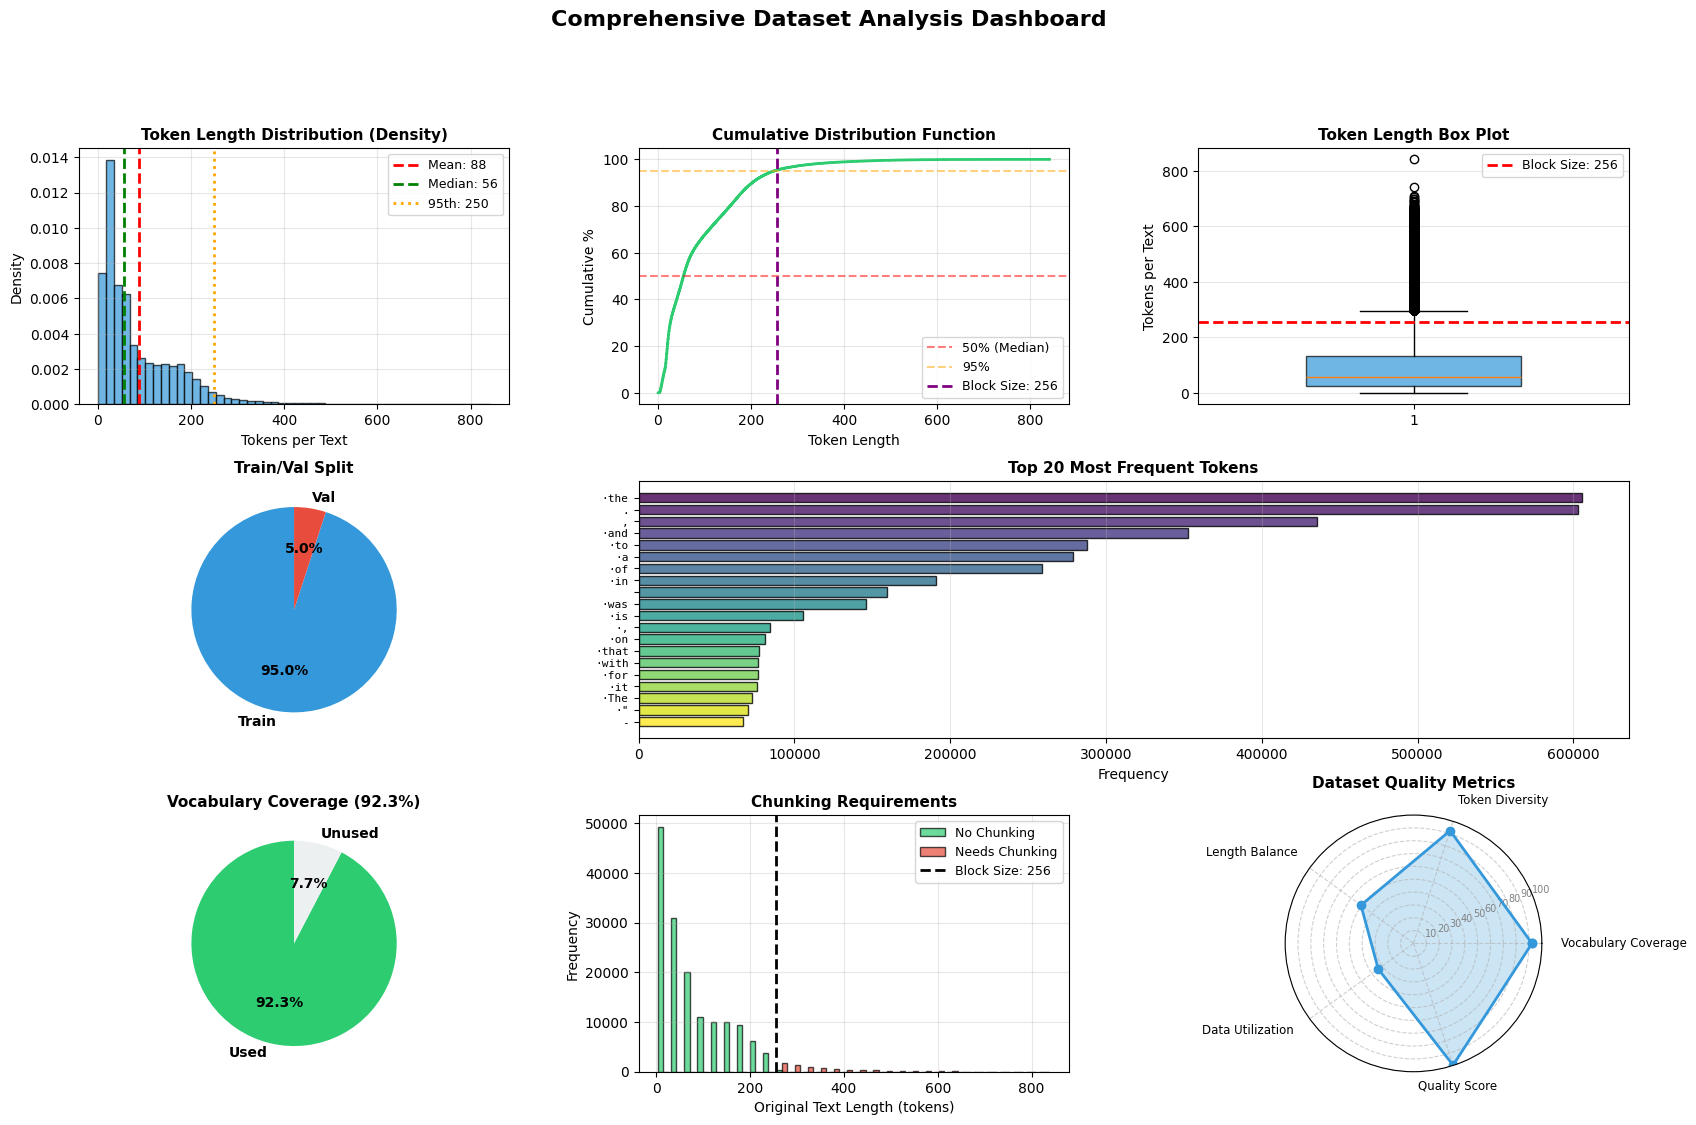


Main Dashboard complete!

────────────────────────────────────────────────────────────────────────────────────────────────────
Creating Training Volume Chart...
────────────────────────────────────────────────────────────────────────────────────────────────────



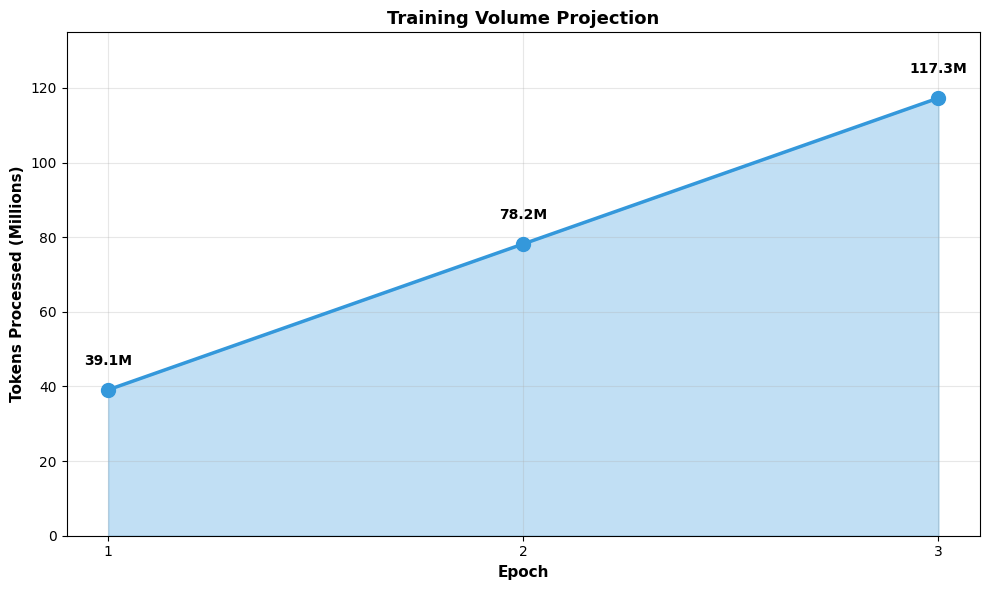


Training Volume chart complete!

────────────────────────────────────────────────────────────────────────────────────────────────────
Creating Dataset Breakdown Dashboard...
────────────────────────────────────────────────────────────────────────────────────────────────────



/tmp/ipython-input-704043797.py:293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


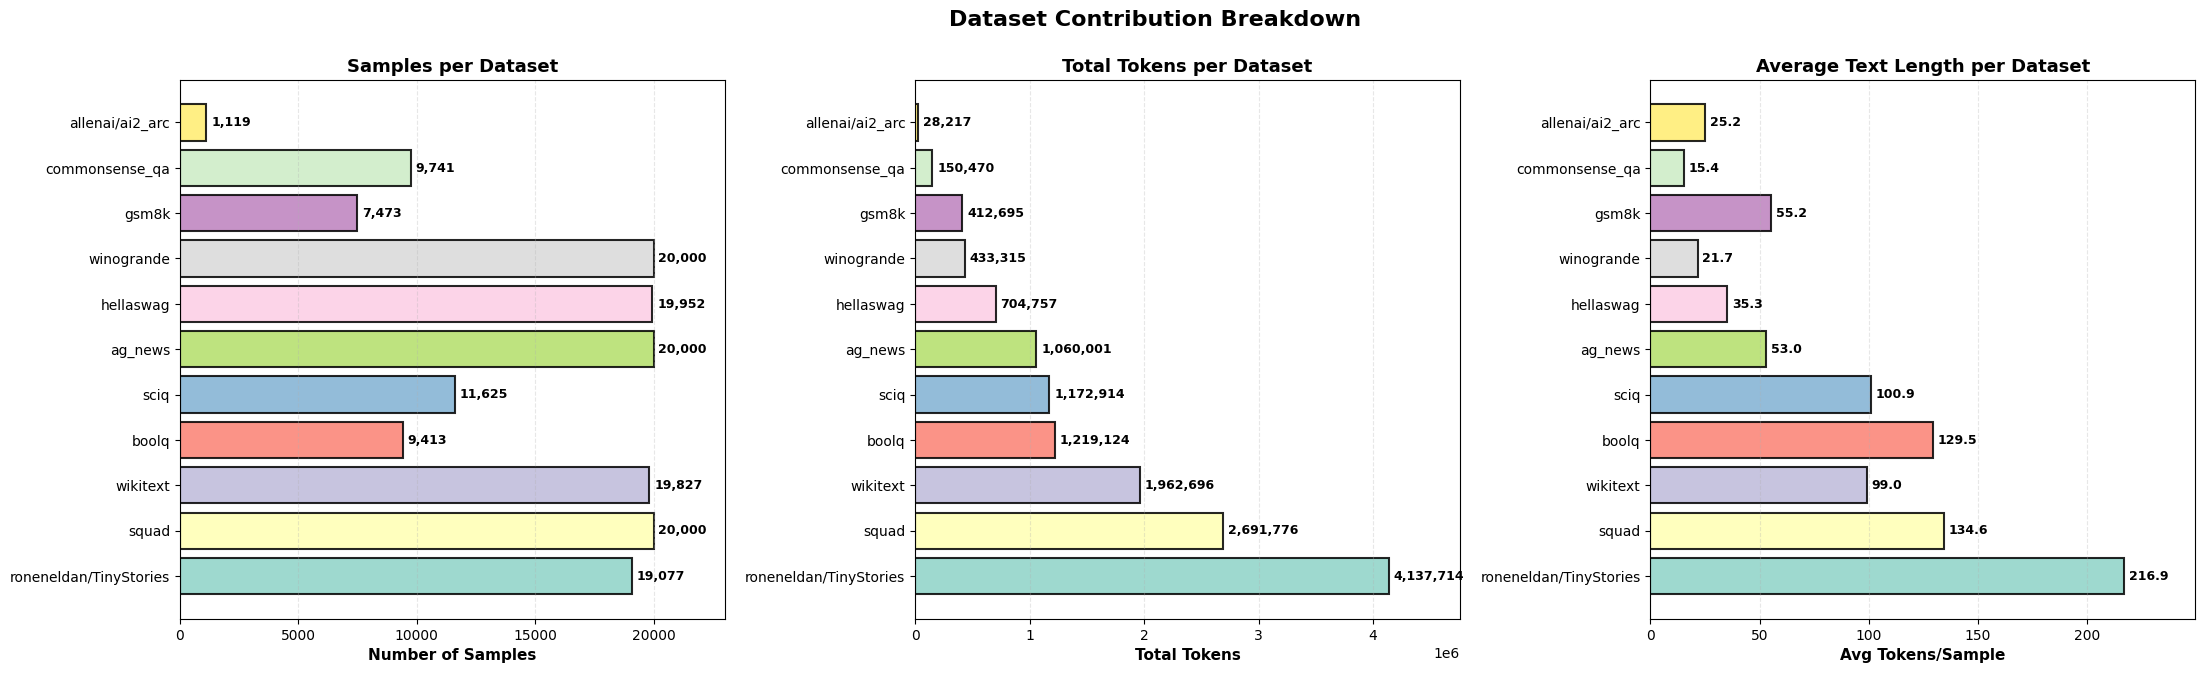


Dataset Breakdown Dashboard complete!

Dataset tracking visualizations generated (3 comprehensive charts)

ALL VISUALIZATIONS COMPLETE!

Generated:
  Main Dashboard (3x3): 8 comprehensive charts
  Training Volume: 1 dedicated chart
  Dataset Breakdown (1x3): 3 dataset-specific charts

  TOTAL: 12 professional visualizations



In [5]:

# DATA VISUALIZATION

print("\n" + "=" * 100)
print(" " * 30 + "GENERATING VISUALIZATIONS...")
print("=" * 100)

raw_token_lengths = [len(tokenizer.encode(t)) for t in text_subset]
total_raw_tokens = sum(raw_token_lengths)
# Recalculate statistics for visualization
train_size = len(train_dataset)
val_size = len(val_dataset)

token_stats = {
    "Mean": np.mean(raw_token_lengths),
    "Median": np.median(raw_token_lengths),
    "Std Dev": np.std(raw_token_lengths),
    "95th percentile": np.percentile(raw_token_lengths, 95),
}

cv = (token_stats["Std Dev"] / token_stats["Mean"]) * 100

all_tokens = [tok for t in text_subset for tok in tokenizer.encode(t)]
unique_tokens = len(set(all_tokens))
vocab_coverage = (unique_tokens / vocab_size) * 100

utilization = (total_raw_tokens / (len(full_dataset) * BLOCK_SIZE)) * 100

quality_score = 100 - (0 * 0.5 + abs(1 - (np.std(raw_token_lengths) / np.mean(raw_token_lengths))) * 20)
quality_score = max(0, min(100, quality_score))

freq = Counter(all_tokens)

steps_per_epoch = len(train_loader)
tokens_per_epoch = len(train_loader) * BATCH_SIZE * BLOCK_SIZE

# Check if dataset tracking is available
if 'dataset_origins' in locals() and 'df_contributions' in locals():
    dataset_names = df_contributions['Dataset'].tolist()
    dataset_tokens = df_contributions['Total Tokens'].tolist()
    dataset_samples = df_contributions['Samples'].tolist()
    has_dataset_tracking = True
else:
    dataset_names = None
    dataset_tokens = None
    dataset_samples = None
    has_dataset_tracking = False


#====== Dashboard
print("\n" + "─" * 100)
print("Creating Main Dashboard (3x3 grid)...")
print("─" * 100 + "\n")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Chart 1: Token length distribution (density plot)
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(raw_token_lengths, bins=50, color='#3498db', edgecolor='black', alpha=0.7, density=True)
ax1.axvline(token_stats["Mean"], color='red', linestyle='--', linewidth=2, label=f'Mean: {token_stats["Mean"]:.0f}')
ax1.axvline(token_stats["Median"], color='green', linestyle='--', linewidth=2, label=f'Median: {token_stats["Median"]:.0f}')
ax1.axvline(token_stats["95th percentile"], color='orange', linestyle=':', linewidth=2, label=f'95th: {token_stats["95th percentile"]:.0f}')
ax1.set_title('Token Length Distribution (Density)', fontweight='bold', fontsize=11)
ax1.set_xlabel('Tokens per Text')
ax1.set_ylabel('Density')
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)


# Chart 2: Cumulative distribution function
ax2 = fig.add_subplot(gs[0, 1])
sorted_lengths = np.sort(raw_token_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
ax2.plot(sorted_lengths, cumulative, linewidth=2, color='#2ecc71')
ax2.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% (Median)')
ax2.axhline(95, color='orange', linestyle='--', alpha=0.5, label='95%')
ax2.axvline(BLOCK_SIZE, color='purple', linestyle='--', linewidth=2, label=f'Block Size: {BLOCK_SIZE}')
ax2.set_title('Cumulative Distribution Function', fontweight='bold', fontsize=11)
ax2.set_xlabel('Token Length')
ax2.set_ylabel('Cumulative %')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)


# Chart 3: Box plot of token lengths
ax3 = fig.add_subplot(gs[0, 2])
bp = ax3.boxplot([raw_token_lengths], vert=True, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][0].set_alpha(0.7)
ax3.axhline(BLOCK_SIZE, color='red', linestyle='--', linewidth=2, label=f'Block Size: {BLOCK_SIZE}')
ax3.set_title('Token Length Box Plot', fontweight='bold', fontsize=11)
ax3.set_ylabel('Tokens per Text')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3, axis='y')

# Chart 4: Train/val split pie chart
ax4 = fig.add_subplot(gs[1, 0])
split_data = [train_size, val_size]
colors_split = ['#3498db', '#e74c3c']
ax4.pie(split_data, labels=['Train', 'Val'], autopct='%1.1f%%',
        colors=colors_split, startangle=90,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title('Train/Val Split', fontweight='bold', fontsize=11)


# Chart 5: Top 20 most frequent tokens
ax5 = fig.add_subplot(gs[1, 1:3])
top_20 = freq.most_common(20)

tokens_decoded = []
for tok, _ in top_20:
    decoded = tokenizer.decode([tok])
    decoded = decoded.replace(' ', '·')
    if len(decoded) > 8:
        decoded = decoded[:8] + '...'
    tokens_decoded.append(decoded)

counts_top = [cnt for _, cnt in top_20]
colors_freq = plt.cm.viridis(np.linspace(0, 1, len(tokens_decoded)))
ax5.barh(range(len(tokens_decoded)), counts_top, color=colors_freq, edgecolor='black', alpha=0.8)
ax5.set_yticks(range(len(tokens_decoded)))
ax5.set_yticklabels(tokens_decoded, fontsize=8, family='monospace')
ax5.set_title('Top 20 Most Frequent Tokens', fontweight='bold', fontsize=11)
ax5.set_xlabel('Frequency')
ax5.invert_yaxis()
ax5.grid(alpha=0.3, axis='x')

# Chart 6: Vocabulary coverage pie chart
ax6 = fig.add_subplot(gs[2, 0])
coverage_data = [unique_tokens, vocab_size - unique_tokens]
colors_vocab = ['#2ecc71', '#ecf0f1']
ax6.pie(coverage_data, labels=['Used', 'Unused'], autopct='%1.1f%%',
        colors=colors_vocab, startangle=90,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
ax6.set_title(f'Vocabulary Coverage ({vocab_coverage:.1f}%)', fontweight='bold', fontsize=11)


# Chart 7: Chunking requirements histogram
ax7 = fig.add_subplot(gs[2, 1])
chunk_lengths = [len(tokenizer.encode(t)) for t in text_subset]
needs_chunking = [l for l in chunk_lengths if l > BLOCK_SIZE]
no_chunking = [l for l in chunk_lengths if l <= BLOCK_SIZE]
ax7.hist([no_chunking, needs_chunking], bins=30, label=['No Chunking', 'Needs Chunking'],
         color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax7.axvline(BLOCK_SIZE, color='black', linestyle='--', linewidth=2, label=f'Block Size: {BLOCK_SIZE}')
ax7.set_title('Chunking Requirements', fontweight='bold', fontsize=11)
ax7.set_xlabel('Original Text Length (tokens)')
ax7.set_ylabel('Frequency')
ax7.legend(fontsize=9)
ax7.grid(alpha=0.3)


# Chart 8: Radar chart of quality metrics
ax8 = fig.add_subplot(gs[2, 2], projection='polar')
categories = ['Vocabulary Coverage', 'Token Diversity', 'Length Balance', 'Data Utilization', 'Quality Score']
values = [
    vocab_coverage,
    (unique_tokens / vocab_size) * 100,
    100 - (cv / 2),
    utilization,
    quality_score
]
values += values[:1]  # Close the polygon

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax8.plot(angles, values, 'o-', linewidth=2, color='#3498db')
ax8.fill(angles, values, alpha=0.25, color='#3498db')
ax8.set_xticks(angles[:-1])
ax8.set_ylim(0, 100)
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ax8.set_yticks(ticks)
ax8.tick_params(axis='y', labelsize=7, colors='gray')
ax8.set_title('Dataset Quality Metrics', fontweight='bold', fontsize=11, pad=20)
ax8.grid(True, linestyle='--', alpha=0.6)


# Custom label positioning for better readability
label_configs = [
    {'label': 'Vocabulary Coverage', 'distance': 115, 'ha': 'left', 'va': 'center'},
    {'label': 'Token Diversity', 'distance': 112, 'ha': 'left', 'va': 'bottom'},
    {'label': 'Length Balance', 'distance': 112, 'ha': 'right', 'va': 'bottom'},
    {'label': 'Data Utilization', 'distance': 115, 'ha': 'right', 'va': 'center'},
    {'label': 'Quality Score', 'distance': 112, 'ha': 'center', 'va': 'top'},
]

for angle, config in zip(angles[:-1], label_configs):
    ax8.text(angle, config['distance'], config['label'],
             ha=config['ha'], va=config['va'], fontsize=8.5)

ax8.set_xticklabels([])

plt.suptitle('Comprehensive Dataset Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "=" * 100)
print("Main Dashboard complete!")
print("=" * 100)

print("\n" + "─" * 100)
print("Creating Training Volume Chart...")
print("─" * 100 + "\n")

fig_training = plt.figure(figsize=(10, 6))
ax_training = fig_training.add_subplot(111)

epoch_nums = np.arange(1, numEpochs + 1)
tokens_processed = [steps_per_epoch * BATCH_SIZE * BLOCK_SIZE * e for e in epoch_nums]

ax_training.plot(epoch_nums, np.array(tokens_processed) / 1e6, marker='o', linewidth=2.5,
                 color='#3498db', markersize=10)
ax_training.fill_between(epoch_nums, 0, np.array(tokens_processed) / 1e6, alpha=0.3, color='#3498db')
ax_training.set_title('Training Volume Projection', fontweight='bold', fontsize=13)
ax_training.set_xlabel('Epoch', fontweight='bold', fontsize=11)
ax_training.set_ylabel('Tokens Processed (Millions)', fontweight='bold', fontsize=11)
ax_training.grid(alpha=0.3)

max_val = max(np.array(tokens_processed) / 1e6)
offset = max_val * 0.05

for i, (e, t) in enumerate(zip(epoch_nums, tokens_processed)):
    ax_training.text(e, t / 1e6 + offset, f'{t/1e6:.1f}M', ha='center', va='bottom',
                     fontsize=10, fontweight='bold')

ax_training.set_ylim(0, max_val * 1.15)
ax_training.set_xticks(epoch_nums)

plt.tight_layout()
plt.show()

print("\n" + "=" * 100)
print("Training Volume chart complete!")
print("=" * 100)

if has_dataset_tracking:
    print("\n" + "─" * 100)
    print("Creating Dataset Breakdown Dashboard...")
    print("─" * 100 + "\n")

    fig_dataset = plt.figure(figsize=(26, 7))
    gs_dataset = fig_dataset.add_gridspec(1, 3, hspace=0.3, wspace=0.35)

    colors = plt.cm.Set3(np.linspace(0, 1, len(dataset_names)))

    ax_samples = fig_dataset.add_subplot(gs_dataset[0, 0])
    bars_samples = ax_samples.barh(range(len(dataset_names)), dataset_samples,
                                   color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)
    ax_samples.set_yticks(range(len(dataset_names)))
    ax_samples.set_yticklabels(dataset_names, fontsize=10)

    for i, (name, val) in enumerate(zip(dataset_names, dataset_samples)):
        ax_samples.text(val + max(dataset_samples) * 0.01, i, f'{int(val):,}',
                       va='center', fontsize=9, fontweight='bold')

    ax_samples.set_xlabel('Number of Samples', fontweight='bold', fontsize=11)
    ax_samples.set_title('Samples per Dataset', fontweight='bold', fontsize=13)
    ax_samples.grid(alpha=0.3, axis='x', linestyle='--')
    ax_samples.margins(x=0.15)

    ax_tokens = fig_dataset.add_subplot(gs_dataset[0, 1])
    bars_tokens = ax_tokens.barh(range(len(dataset_names)), dataset_tokens,
                                color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)
    ax_tokens.set_yticks(range(len(dataset_names)))
    ax_tokens.set_yticklabels(dataset_names, fontsize=10)

    for i, (name, val) in enumerate(zip(dataset_names, dataset_tokens)):
        ax_tokens.text(val + max(dataset_tokens) * 0.01, i, f'{int(val):,}',
                      va='center', fontsize=9, fontweight='bold')

    ax_tokens.set_xlabel('Total Tokens', fontweight='bold', fontsize=11)
    ax_tokens.set_title('Total Tokens per Dataset', fontweight='bold', fontsize=13)
    ax_tokens.grid(alpha=0.3, axis='x', linestyle='--')
    ax_tokens.margins(x=0.15)

    ax_avg = fig_dataset.add_subplot(gs_dataset[0, 2])
    avg_tokens_per_dataset = [t/s for t, s in zip(dataset_tokens, dataset_samples)]
    bars_avg = ax_avg.barh(range(len(dataset_names)), avg_tokens_per_dataset,
                           color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)
    ax_avg.set_yticks(range(len(dataset_names)))
    ax_avg.set_yticklabels(dataset_names, fontsize=10)

    for i, (name, val) in enumerate(zip(dataset_names, avg_tokens_per_dataset)):
        ax_avg.text(val + max(avg_tokens_per_dataset) * 0.01, i, f'{val:.1f}',
                   va='center', fontsize=9, fontweight='bold')

    ax_avg.set_xlabel('Avg Tokens/Sample', fontweight='bold', fontsize=11)
    ax_avg.set_title('Average Text Length per Dataset', fontweight='bold', fontsize=13)
    ax_avg.grid(alpha=0.3, axis='x', linestyle='--')
    ax_avg.margins(x=0.15)

    fig_dataset.suptitle('Dataset Contribution Breakdown', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 100)
    print("Dataset Breakdown Dashboard complete!")
    print("=" * 100)
    print("\nDataset tracking visualizations generated (3 comprehensive charts)")
else:
    print("\nWARNING: Dataset breakdown plots not available (dataset_origins not found)")
    print("Use DATA_COLLECTION_UPDATED.py to enable dataset tracking")

print("\n" + "=" * 100)
print("ALL VISUALIZATIONS COMPLETE!")
print("=" * 100)
print("\nGenerated:")
print("  Main Dashboard (3x3): 8 comprehensive charts")
print("  Training Volume: 1 dedicated chart")
if has_dataset_tracking:
    print("  Dataset Breakdown (1x3): 3 dataset-specific charts")
    print("\n  TOTAL: 12 professional visualizations")
else:
    print("\n  TOTAL: 9 professional visualizations")
print("\n" + "=" * 100)

In [6]:
class LLmini(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model,
        pad_token_id,
        num_heads=1,
        num_layers=8,
        block_size=BLOCK_SIZE,
    ):
        super().__init__()
        self.pad_token_id = pad_token_id
        self.block_size = block_size

        # Embedding layers
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos = nn.Embedding(block_size, d_model)  # Positional embeddings


         # Transformer blocks
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                "ln1": nn.LayerNorm(d_model),  # Pre-attention LayerNorm
                "attn": nn.MultiheadAttention(
                    d_model,
                    num_heads,
                    dropout=0.1,
                    batch_first=True,
                ),
                "ln2": nn.LayerNorm(d_model), # Pre-FFN LayerNorm
                "ff": nn.Sequential(          # Feed-forward network (MLP)
                    nn.Linear(d_model, 4 * d_model),
                    nn.GELU(),
                    nn.Linear(4 * d_model, d_model),
                    nn.Dropout(0.3),
                ),
                "drop": nn.Dropout(0.3), # Residual dropout
            })
            for _ in range(num_layers)
        ])

        # Output layers
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, x, targets=None):
        B, T = x.size()

        positions = torch.arange(T, device=x.device)
        x = self.emb(x) + self.pos(positions)[None, :, :]

        mask = torch.triu(
            torch.full((T, T), float("-inf"), device=x.device),
            diagonal=1,
        )

        for block in self.blocks:
          # Multi-head self-attention with residual connection
            attn_in = block["ln1"](x)
            attn_out, _ = block["attn"](
                attn_in,
                attn_in,
                attn_in,
                attn_mask=mask,
            )
            x = x + block["drop"](attn_out)

            ff_in = block["ln2"](x) # Feed-forward network with residual connection
            x = x + block["ff"](ff_in)

        logits = self.lm_head(self.ln_f(x))

        if targets is None:
            return logits

        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)),
            targets.reshape(-1),
            ignore_index=self.pad_token_id,
        )
        return logits, loss

print(f"\n{'='*70}")
print("Creating LLmini model...")
print(f"{'='*70}\n")

torch.manual_seed(SEED)
np.random.seed(SEED)

model = LLmini(
    vocab_size=vocab_size,
    d_model=320,
    num_heads=5,
    num_layers=9,
    pad_token_id=tokenizer.pad_token_id,
    block_size=BLOCK_SIZE,
).to(device)

print(f"Model created with SEED={SEED}")
print(f"  Context window: {BLOCK_SIZE}")
print(f"  Device: {device}")
print(f"{'='*70}\n")


Creating LLmini model...

Model created with SEED=42
  Context window: 256
  Device: cuda



In [7]:
training_start_time = time.time()
training_start_ram = psutil.virtual_memory().used / 1024**3
training_start_disk = shutil.disk_usage("/").used / 1024**3

print(f"\n{'='*70}")
print("TRAINING PHASE - Initial Resources")
print(f"{'='*70}")
print(f"Training started at:  {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"System RAM usage:     {training_start_ram:.2f} GB")
print(f"GPU VRAM allocated:   {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Disk space used:      {training_start_disk:.2f} GB")
print(f"Data loading time:    {(training_start_time - start_time)/60:.1f} min")
print(f"{'='*70}\n")



TRAINING PHASE - Initial Resources
Training started at:  2026-02-05 18:05:49
System RAM usage:     4.48 GB
GPU VRAM allocated:   0.16 GB
Disk space used:      41.74 GB
Data loading time:    8.1 min



In [8]:
# ------- TRAINING SETUP

from torch.cuda.amp import autocast, GradScaler

save_dir = "/content/LLmini_STEM_model"
os.makedirs(save_dir, exist_ok=True)

# Batch configuration for optimal GPU utilization
BATCH_SIZE = 32
GRADIENT_ACCUMULATION_STEPS = 2  # simulates batch size of 64
EFFECTIVE_BATCH_SIZE = BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS

# Training hyperparameters
EPOCHS = 3
PRINT_EVERY = 200
MAX_NEW_TOKENS = 50
TEMPERATURE = 1.0
TOP_K = 20
PATIENCE = 3
LEARNING_RATE = 3e-4  # scaled for effective batch 64
WEIGHT_DECAY = 0.05  # L2 regularization
GRAD_CLIP = 1.0  # gradient clipping for stability


# Metrics tracking
train_losses_per_step = []
train_losses_per_epoch = []
val_losses_per_epoch = []
train_ppls_per_epoch = []
val_ppls_per_epoch = []

print(f"\n{'='*70}")
print("Creating optimizer...")
print(f"{'='*70}\n")

torch.manual_seed(SEED)
np.random.seed(SEED)

# AdamW optimizer with weight decay decoupled from gradient updates
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Mixed precision training for faster computation and lower memory usage
scaler = GradScaler()

print(f"Optimizer created with SEED={SEED}")
print(f"{'='*70}\n")

# Learning rate scheduling
total_steps = (len(train_loader) * EPOCHS) // GRADIENT_ACCUMULATION_STEPS
warmup_steps = int(total_steps * 0.1)  # 10% warmup for training stability
step_count = 0

# Early stopping to prevent overfitting
best_val_loss = float("inf")
patience_counter = 0

print(f"Training configuration:")
print(f"  - Batch size (physical): {BATCH_SIZE}")
print(f"  - Gradient accumulation: {GRADIENT_ACCUMULATION_STEPS}")
print(f"  - Effective batch size: {EFFECTIVE_BATCH_SIZE}")
print(f"  - Total epochs: {EPOCHS}")
print(f"  - Warmup steps: {warmup_steps}")
print(f"  - Total steps: {total_steps}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Weight decay: {WEIGHT_DECAY}")
print(f"{'='*70}\n")

def get_lr(step, total_steps, warmup_steps, base_lr):
    """Cosine annealing schedule with linear warmup"""
    if step < warmup_steps:
        return base_lr * step / warmup_steps
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    return base_lr * 0.5 * (1 + math.cos(math.pi * progress))

@torch.no_grad()
def generate(model, prompt, max_new_tokens=MAX_NEW_TOKENS, temperature=TEMPERATURE, top_k=TOP_K, seed=SEED):
    """Generate text using top-k sampling with temperature scaling"""
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    model.eval()
    x = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    for _ in range(max_new_tokens):
        logits = model(x)[:, -1, :] / temperature
        topk_vals, _ = torch.topk(logits, top_k)
        logits = torch.where(
            logits < topk_vals[:, -1].unsqueeze(1),
            torch.full_like(logits, float("-inf")),
            logits,
        )
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, 1)
        x = torch.cat([x, next_token], dim=1)

    return tokenizer.decode(x[0], skip_special_tokens=True)


# Training loop with mixed precision and gradient accumulation
print(f"\n{'='*70}")
print("STARTING TRAINING")
print(f"{'='*70}\n")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    # Training phase
    for i, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}")):
        x, y = x.to(device), y.to(device)

        # Mixed precision forward pass for efficiency
        with autocast():
            _, loss = model(x, y)
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        # Scaled backward pass
        scaler.scale(loss).backward()

        # Perform optimizer step after accumulating gradients
        if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            # Update learning rate with cosine schedule
            lr = get_lr(step_count, total_steps, warmup_steps, LEARNING_RATE)
            optimizer.param_groups[0]["lr"] = lr

            # Gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

            # Update model weights
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            step_count += 1

        # Track metrics
        loss_val = loss.item() * GRADIENT_ACCUMULATION_STEPS
        total_loss += loss_val
        train_losses_per_step.append(loss_val)

        if i % PRINT_EVERY == 0:
            print(f"Epoch {epoch + 1} | Step {i:6d} | Loss {loss_val:.4f} | LR {optimizer.param_groups[0]['lr']:.2e}")

    # Compute epoch metrics
    avg_train_loss = total_loss / len(train_loader)
    train_losses_per_epoch.append(avg_train_loss)

    # Perplexity calculation with warning for high loss
    if avg_train_loss > 10:
        print(f"!!! WARNING: Train loss = {avg_train_loss:.2f} (> 10) - training may have issues!")
    train_ppls_per_epoch.append(math.exp(min(avg_train_loss, 10)))


    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            with autocast():
                _, loss_val = model(x_val, y_val)

            val_loss += loss_val.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses_per_epoch.append(avg_val_loss)

    # Perplexity calculation with warning for high loss
    if avg_val_loss > 10:
        print(f"!!! WARNING: Val loss = {avg_val_loss:.2f} (> 10) - validation loss too high!")
    val_ppls_per_epoch.append(math.exp(min(avg_val_loss, 10)))

    print("\n" + "=" * 60)
    print(f"Epoch {epoch + 1} completed")
    print(f"Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f}")
    print(f"Train PPL:  {train_ppls_per_epoch[-1]:.2f} | Val PPL:  {val_ppls_per_epoch[-1]:.2f}")
    print("=" * 60 + "\n")

    # Save best model checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'step_count': step_count,
        }, os.path.join(save_dir, "best_model.pt"))

        print("Best model updated!")
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{PATIENCE}")

        # Early stopping to prevent overfitting
        if patience_counter >= PATIENCE:
            print(f"Early stopping. Best val loss: {best_val_loss:.4f}")
            break

print(f"\n{'='*70}")
print("TRAINING COMPLETED")
print(f"{'='*70}\n")


Creating optimizer...



/tmp/ipython-input-534418149.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Optimizer created with SEED=42

Training configuration:
  - Batch size (physical): 32
  - Gradient accumulation: 2
  - Effective batch size: 64
  - Total epochs: 3
  - Warmup steps: 715
  - Total steps: 7159
  - Learning rate: 0.0003
  - Weight decay: 0.05


STARTING TRAINING




Epoch 1:   0%|          | 0/4773 [00:00<?, ?it/s]/tmp/ipython-input-534418149.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1:   0%|          | 1/4773 [00:01<1:29:08,  1.12s/it]

Epoch 1 | Step      0 | Loss 10.9691 | LR 3.00e-04


Epoch 1:   4%|▍         | 201/4773 [00:46<17:01,  4.48it/s]

Epoch 1 | Step    200 | Loss 9.4377 | LR 4.15e-05


Epoch 1:   8%|▊         | 401/4773 [01:31<16:38,  4.38it/s]

Epoch 1 | Step    400 | Loss 7.6712 | LR 8.35e-05


Epoch 1:  13%|█▎        | 601/4773 [02:18<16:07,  4.31it/s]

Epoch 1 | Step    600 | Loss 7.3198 | LR 1.25e-04


Epoch 1:  17%|█▋        | 801/4773 [03:05<15:18,  4.33it/s]

Epoch 1 | Step    800 | Loss 6.8826 | LR 1.67e-04


Epoch 1:  21%|██        | 1001/4773 [03:51<14:41,  4.28it/s]

Epoch 1 | Step   1000 | Loss 5.9576 | LR 2.09e-04


Epoch 1:  25%|██▌       | 1201/4773 [04:38<13:50,  4.30it/s]

Epoch 1 | Step   1200 | Loss 6.2595 | LR 2.51e-04


Epoch 1:  29%|██▉       | 1401/4773 [05:25<12:59,  4.32it/s]

Epoch 1 | Step   1400 | Loss 5.7546 | LR 2.93e-04


Epoch 1:  34%|███▎      | 1601/4773 [06:11<12:16,  4.31it/s]

Epoch 1 | Step   1600 | Loss 6.2231 | LR 3.00e-04


Epoch 1:  38%|███▊      | 1801/4773 [06:58<11:27,  4.33it/s]

Epoch 1 | Step   1800 | Loss 5.5595 | LR 2.99e-04


Epoch 1:  42%|████▏     | 2001/4773 [07:45<10:41,  4.32it/s]

Epoch 1 | Step   2000 | Loss 6.1327 | LR 2.99e-04


Epoch 1:  46%|████▌     | 2201/4773 [08:32<09:54,  4.33it/s]

Epoch 1 | Step   2200 | Loss 6.4033 | LR 2.97e-04


Epoch 1:  50%|█████     | 2401/4773 [09:18<09:09,  4.31it/s]

Epoch 1 | Step   2400 | Loss 5.2247 | LR 2.96e-04


Epoch 1:  54%|█████▍    | 2601/4773 [10:05<08:27,  4.28it/s]

Epoch 1 | Step   2600 | Loss 5.4020 | LR 2.94e-04


Epoch 1:  59%|█████▊    | 2801/4773 [10:52<07:37,  4.31it/s]

Epoch 1 | Step   2800 | Loss 5.6718 | LR 2.92e-04


Epoch 1:  63%|██████▎   | 3001/4773 [11:39<06:51,  4.31it/s]

Epoch 1 | Step   3000 | Loss 5.1381 | LR 2.89e-04


Epoch 1:  67%|██████▋   | 3201/4773 [12:25<06:05,  4.30it/s]

Epoch 1 | Step   3200 | Loss 5.6154 | LR 2.86e-04


Epoch 1:  71%|███████▏  | 3401/4773 [13:12<05:17,  4.32it/s]

Epoch 1 | Step   3400 | Loss 5.1599 | LR 2.83e-04


Epoch 1:  75%|███████▌  | 3601/4773 [13:59<04:30,  4.33it/s]

Epoch 1 | Step   3600 | Loss 5.2843 | LR 2.80e-04


Epoch 1:  80%|███████▉  | 3801/4773 [14:45<03:44,  4.33it/s]

Epoch 1 | Step   3800 | Loss 5.4281 | LR 2.76e-04


Epoch 1:  84%|████████▍ | 4001/4773 [15:32<02:58,  4.33it/s]

Epoch 1 | Step   4000 | Loss 5.1928 | LR 2.72e-04


Epoch 1:  88%|████████▊ | 4201/4773 [16:19<02:12,  4.31it/s]

Epoch 1 | Step   4200 | Loss 4.4063 | LR 2.67e-04


Epoch 1:  92%|█████████▏| 4401/4773 [17:06<01:26,  4.30it/s]

Epoch 1 | Step   4400 | Loss 5.3114 | LR 2.62e-04


Epoch 1:  96%|█████████▋| 4601/4773 [17:52<00:40,  4.28it/s]

Epoch 1 | Step   4600 | Loss 5.2981 | LR 2.57e-04


Epoch 1: 100%|██████████| 4773/4773 [18:32<00:00,  4.29it/s]
/tmp/ipython-input-534418149.py:170: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1 completed
Train loss: 6.0290 | Val loss: 4.9024
Train PPL:  415.29 | Val PPL:  134.61

Best model updated!


Epoch 2:   0%|          | 1/4773 [00:00<24:47,  3.21it/s]

Epoch 2 | Step      0 | Loss 5.0383 | LR 2.53e-04


Epoch 2:   4%|▍         | 201/4773 [00:47<17:40,  4.31it/s]

Epoch 2 | Step    200 | Loss 4.3303 | LR 2.48e-04


Epoch 2:   8%|▊         | 401/4773 [01:33<16:55,  4.31it/s]

Epoch 2 | Step    400 | Loss 5.2684 | LR 2.42e-04


Epoch 2:  13%|█▎        | 601/4773 [02:20<16:03,  4.33it/s]

Epoch 2 | Step    600 | Loss 4.8867 | LR 2.36e-04


Epoch 2:  17%|█▋        | 801/4773 [03:07<15:17,  4.33it/s]

Epoch 2 | Step    800 | Loss 4.7952 | LR 2.30e-04


Epoch 2:  21%|██        | 1001/4773 [03:54<14:30,  4.33it/s]

Epoch 2 | Step   1000 | Loss 4.8383 | LR 2.24e-04


Epoch 2:  25%|██▌       | 1201/4773 [04:40<13:44,  4.33it/s]

Epoch 2 | Step   1200 | Loss 4.3808 | LR 2.17e-04


Epoch 2:  29%|██▉       | 1401/4773 [05:27<12:59,  4.33it/s]

Epoch 2 | Step   1400 | Loss 4.6752 | LR 2.11e-04


Epoch 2:  34%|███▎      | 1601/4773 [06:14<12:13,  4.33it/s]

Epoch 2 | Step   1600 | Loss 4.7900 | LR 2.04e-04


Epoch 2:  38%|███▊      | 1801/4773 [07:00<11:29,  4.31it/s]

Epoch 2 | Step   1800 | Loss 4.6379 | LR 1.97e-04


Epoch 2:  42%|████▏     | 2001/4773 [07:47<10:42,  4.31it/s]

Epoch 2 | Step   2000 | Loss 4.5905 | LR 1.90e-04


Epoch 2:  46%|████▌     | 2201/4773 [08:34<09:58,  4.30it/s]

Epoch 2 | Step   2200 | Loss 4.8088 | LR 1.83e-04


Epoch 2:  50%|█████     | 2401/4773 [09:21<09:06,  4.34it/s]

Epoch 2 | Step   2400 | Loss 4.7380 | LR 1.76e-04


Epoch 2:  54%|█████▍    | 2601/4773 [10:07<08:22,  4.33it/s]

Epoch 2 | Step   2600 | Loss 4.2068 | LR 1.68e-04


Epoch 2:  59%|█████▊    | 2801/4773 [10:54<07:35,  4.33it/s]

Epoch 2 | Step   2800 | Loss 4.4260 | LR 1.61e-04


Epoch 2:  63%|██████▎   | 3001/4773 [11:41<06:48,  4.33it/s]

Epoch 2 | Step   3000 | Loss 4.3679 | LR 1.54e-04


Epoch 2:  67%|██████▋   | 3201/4773 [12:27<06:05,  4.30it/s]

Epoch 2 | Step   3200 | Loss 4.2494 | LR 1.46e-04


Epoch 2:  71%|███████▏  | 3401/4773 [13:14<05:16,  4.33it/s]

Epoch 2 | Step   3400 | Loss 4.5375 | LR 1.39e-04


Epoch 2:  75%|███████▌  | 3601/4773 [14:01<04:31,  4.32it/s]

Epoch 2 | Step   3600 | Loss 4.8158 | LR 1.32e-04


Epoch 2:  80%|███████▉  | 3801/4773 [14:48<03:46,  4.30it/s]

Epoch 2 | Step   3800 | Loss 4.7571 | LR 1.25e-04


Epoch 2:  84%|████████▍ | 4001/4773 [15:34<02:59,  4.30it/s]

Epoch 2 | Step   4000 | Loss 4.4641 | LR 1.17e-04


Epoch 2:  88%|████████▊ | 4201/4773 [16:21<02:13,  4.29it/s]

Epoch 2 | Step   4200 | Loss 4.4568 | LR 1.10e-04


Epoch 2:  92%|█████████▏| 4401/4773 [17:08<01:26,  4.32it/s]

Epoch 2 | Step   4400 | Loss 4.1830 | LR 1.03e-04


Epoch 2:  96%|█████████▋| 4601/4773 [17:55<00:39,  4.32it/s]

Epoch 2 | Step   4600 | Loss 4.1105 | LR 9.65e-05


Epoch 2: 100%|██████████| 4773/4773 [18:35<00:00,  4.28it/s]



Epoch 2 completed
Train loss: 4.6465 | Val loss: 4.3905
Train PPL:  104.22 | Val PPL:  80.68

Best model updated!


Epoch 3:   0%|          | 1/4773 [00:00<22:15,  3.57it/s]

Epoch 3 | Step      0 | Loss 4.2903 | LR 9.07e-05


Epoch 3:   4%|▍         | 201/4773 [00:47<17:42,  4.30it/s]

Epoch 3 | Step    200 | Loss 4.8821 | LR 8.40e-05


Epoch 3:   8%|▊         | 401/4773 [01:33<16:55,  4.31it/s]

Epoch 3 | Step    400 | Loss 4.8439 | LR 7.75e-05


Epoch 3:  13%|█▎        | 601/4773 [02:20<16:10,  4.30it/s]

Epoch 3 | Step    600 | Loss 4.1948 | LR 7.12e-05


Epoch 3:  17%|█▋        | 801/4773 [03:07<15:30,  4.27it/s]

Epoch 3 | Step    800 | Loss 4.1138 | LR 6.51e-05


Epoch 3:  21%|██        | 1001/4773 [03:54<14:39,  4.29it/s]

Epoch 3 | Step   1000 | Loss 4.2319 | LR 5.92e-05


Epoch 3:  25%|██▌       | 1201/4773 [04:40<13:44,  4.33it/s]

Epoch 3 | Step   1200 | Loss 4.5877 | LR 5.35e-05


Epoch 3:  29%|██▉       | 1401/4773 [05:27<13:00,  4.32it/s]

Epoch 3 | Step   1400 | Loss 4.6469 | LR 4.80e-05


Epoch 3:  34%|███▎      | 1601/4773 [06:14<12:12,  4.33it/s]

Epoch 3 | Step   1600 | Loss 4.8720 | LR 4.28e-05


Epoch 3:  38%|███▊      | 1801/4773 [07:01<11:28,  4.32it/s]

Epoch 3 | Step   1800 | Loss 3.9812 | LR 3.78e-05


Epoch 3:  42%|████▏     | 2001/4773 [07:47<10:44,  4.30it/s]

Epoch 3 | Step   2000 | Loss 4.2699 | LR 3.31e-05


Epoch 3:  46%|████▌     | 2201/4773 [08:34<09:55,  4.32it/s]

Epoch 3 | Step   2200 | Loss 4.0434 | LR 2.86e-05


Epoch 3:  50%|█████     | 2401/4773 [09:21<09:09,  4.32it/s]

Epoch 3 | Step   2400 | Loss 4.6737 | LR 2.45e-05


Epoch 3:  54%|█████▍    | 2601/4773 [10:08<08:25,  4.30it/s]

Epoch 3 | Step   2600 | Loss 3.8788 | LR 2.06e-05


Epoch 3:  59%|█████▊    | 2801/4773 [10:54<07:40,  4.28it/s]

Epoch 3 | Step   2800 | Loss 4.9084 | LR 1.71e-05


Epoch 3:  63%|██████▎   | 3001/4773 [11:41<06:49,  4.32it/s]

Epoch 3 | Step   3000 | Loss 4.0759 | LR 1.38e-05


Epoch 3:  67%|██████▋   | 3201/4773 [12:28<06:03,  4.32it/s]

Epoch 3 | Step   3200 | Loss 4.0186 | LR 1.09e-05


Epoch 3:  71%|███████▏  | 3401/4773 [13:14<05:17,  4.32it/s]

Epoch 3 | Step   3400 | Loss 4.1393 | LR 8.36e-06


Epoch 3:  75%|███████▌  | 3601/4773 [14:01<04:32,  4.31it/s]

Epoch 3 | Step   3600 | Loss 4.6463 | LR 6.12e-06


Epoch 3:  80%|███████▉  | 3801/4773 [14:48<03:44,  4.32it/s]

Epoch 3 | Step   3800 | Loss 3.8618 | LR 4.23e-06


Epoch 3:  84%|████████▍ | 4001/4773 [15:35<02:58,  4.33it/s]

Epoch 3 | Step   4000 | Loss 4.2655 | LR 2.68e-06


Epoch 3:  88%|████████▊ | 4201/4773 [16:21<02:12,  4.31it/s]

Epoch 3 | Step   4200 | Loss 4.3659 | LR 1.48e-06


Epoch 3:  92%|█████████▏| 4401/4773 [17:08<01:26,  4.31it/s]

Epoch 3 | Step   4400 | Loss 4.8192 | LR 6.30e-07


Epoch 3:  96%|█████████▋| 4601/4773 [17:55<00:39,  4.30it/s]

Epoch 3 | Step   4600 | Loss 4.7871 | LR 1.38e-07


Epoch 3: 100%|██████████| 4773/4773 [18:35<00:00,  4.28it/s]



Epoch 3 completed
Train loss: 4.3197 | Val loss: 4.3009
Train PPL:  75.17 | Val PPL:  73.77

Best model updated!

TRAINING COMPLETED



In [9]:
training_end_time = time.time()
training_end_ram = psutil.virtual_memory().used / 1024**3  # GB

print(f"\n{'='*70}")
print("TRAINING PHASE COMPLETED")
print(f"{'='*70}")
print(f"Training duration:    {(training_end_time - training_start_time) / 60:.1f} min")
print(f"Final system RAM:     {training_end_ram:.2f} GB")
print(f"  - Training delta:   {training_end_ram - training_start_ram:+.2f} GB")
print(f"Final GPU VRAM:       {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Peak GPU VRAM:        {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")
print(f"{'='*70}\n")



TRAINING PHASE COMPLETED
Training duration:    57.8 min
Final system RAM:     4.89 GB
  - Training delta:   +0.41 GB
Final GPU VRAM:       0.79 GB
Peak GPU VRAM:        6.85 GB



In [10]:
torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))

best_model_path = os.path.join(save_dir, "best_model.bin")
if os.path.exists(best_model_path):
    print("Best model already saved during training")
else:
    print("No best model found")

model_config = {
    "vocab_size": vocab_size,
    "d_model": model.emb.embedding_dim,
    "num_heads": model.blocks[0]["attn"].num_heads,
    "num_layers": len(model.blocks),
    "block_size": BLOCK_SIZE,
    "pad_token_id": tokenizer.pad_token_id,
    "seed": SEED,
}

with open(os.path.join(save_dir, "model_config.json"), "w") as f:
    json.dump(model_config, f, indent=4)

tokenizer.save_pretrained(save_dir)

print("\n" + "=" * 60)
print(f"Model saved to: {save_dir}")
print("Files:")
print(" - pytorch_model.bin")
print(" - best_model.bin")
print(" - model_config.json")
print(" - tokenizer files")
print("=" * 60)

No best model found

Model saved to: /content/LLmini_STEM_model
Files:
 - pytorch_model.bin
 - best_model.bin
 - model_config.json
 - tokenizer files


In [11]:
#shutil.make_archive("/content/LLmini_STEM_model", 'zip', "/content/LLmini_STEM_model")
#files.download("/content/LLmini_STEM_model.zip")


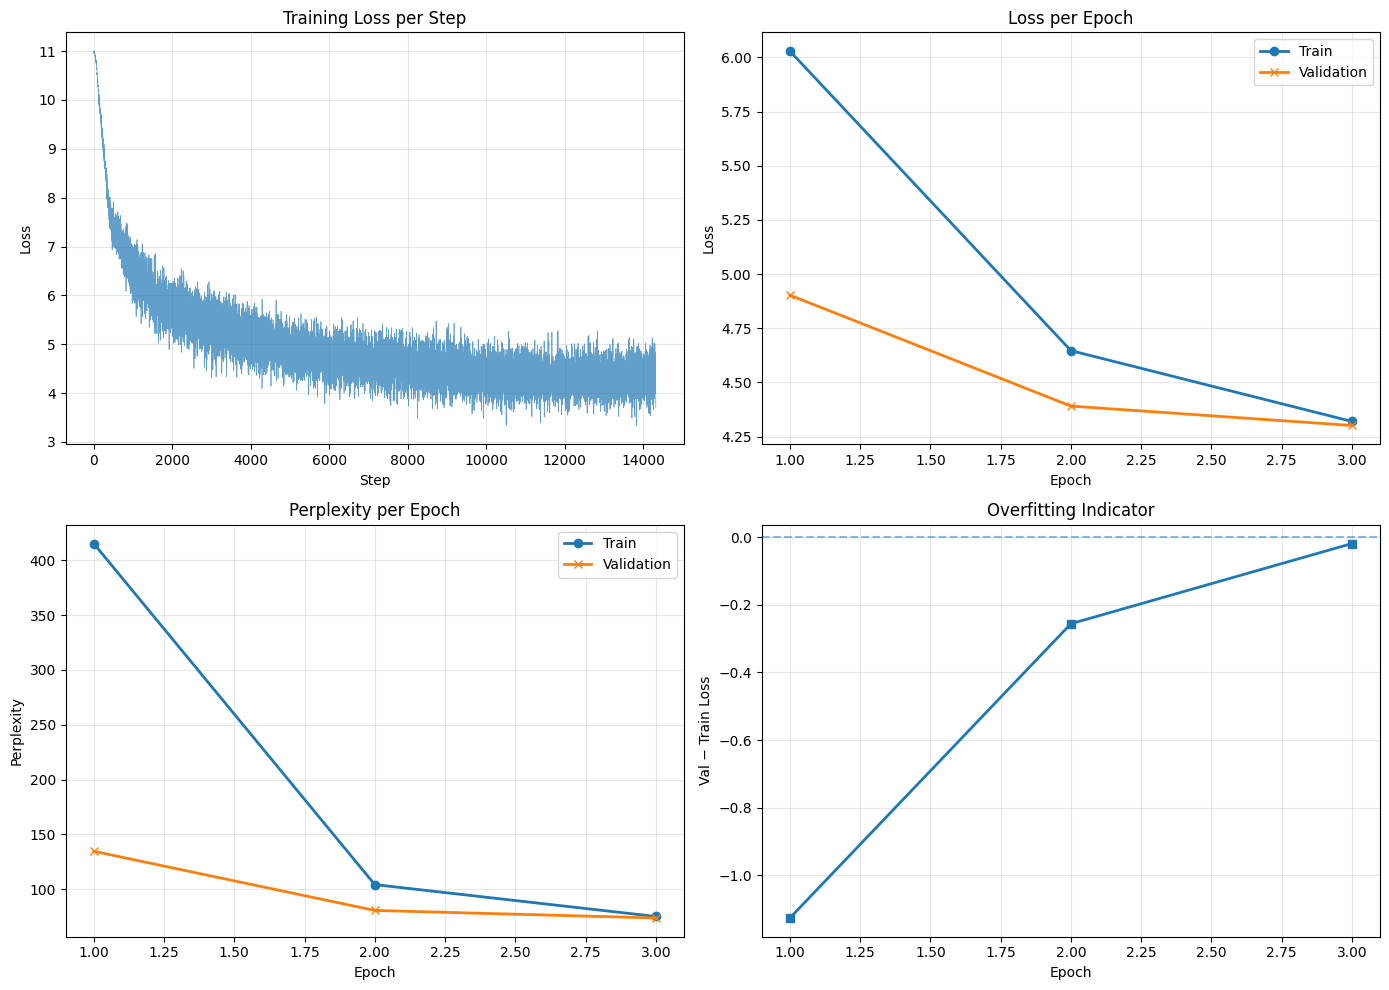


LOSS PER EPOCH
 Epoch  Train Loss  Validation Loss
     1    6.028974         4.902379
     2    4.646537         4.390504
     3    4.319702         4.300941

PERPLEXITY PER EPOCH
 Epoch  Train Perplexity  Validation Perplexity
     1          415.2885               134.6097
     2          104.2234                80.6811
     3           75.1662                73.7692

OVERFITTING INDICATOR
 Epoch  Val - Train Loss
     1         -1.126594
     2         -0.256033
     3         -0.018761


In [12]:
  #-- TRAINING METRICS VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs = range(1, len(train_losses_per_epoch) + 1)


axes[0, 0].plot(train_losses_per_step, linewidth=0.5, alpha=0.7)
axes[0, 0].set(title="Training Loss per Step", xlabel="Step", ylabel="Loss")
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(epochs, train_losses_per_epoch, marker="o", linewidth=2, label="Train")
axes[0, 1].plot(epochs, val_losses_per_epoch, marker="x", linewidth=2, label="Validation")
axes[0, 1].set(title="Loss per Epoch", xlabel="Epoch", ylabel="Loss")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(epochs, train_ppls_per_epoch, marker="o", linewidth=2, label="Train")
axes[1, 0].plot(epochs, val_ppls_per_epoch, marker="x", linewidth=2, label="Validation")
axes[1, 0].set(title="Perplexity per Epoch", xlabel="Epoch", ylabel="Perplexity")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

gap = [v - t for t, v in zip(train_losses_per_epoch, val_losses_per_epoch)]
axes[1, 1].plot(epochs, gap, marker="s", linewidth=2)
axes[1, 1].axhline(0, linestyle="--", alpha=0.5)
axes[1, 1].set(title="Overfitting Indicator", xlabel="Epoch", ylabel="Val − Train Loss")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

df_loss = pd.DataFrame({
    "Epoch": epochs,
    "Train Loss": train_losses_per_epoch,
    "Validation Loss": val_losses_per_epoch
})
print("\nLOSS PER EPOCH")
print(df_loss.to_string(index=False, float_format="{:.6f}".format))

df_ppl = pd.DataFrame({
    "Epoch": epochs,
    "Train Perplexity": train_ppls_per_epoch,
    "Validation Perplexity": val_ppls_per_epoch
})
print("\nPERPLEXITY PER EPOCH")
print(df_ppl.to_string(index=False, float_format="{:.4f}".format))

df_gap = pd.DataFrame({
    "Epoch": epochs,
    "Val - Train Loss": gap
})
print("\nOVERFITTING INDICATOR")
print(df_gap.to_string(index=False, float_format="{:+.6f}".format))





DEBUG - ATTENTION WEIGHTS VERIFICATION

Layer 1:
  Shape: torch.Size([32, 5, 256, 256])
  Min: 0.000000
  Max: 1.000000
  Mean: 0.003906
  Sum per row: 1.000000
  Uniform value: 0.003906
  Diff from uniform: 0.000000

Layer 2:
  Shape: torch.Size([32, 5, 256, 256])
  Min: 0.000000
  Max: 1.000000
  Mean: 0.003906
  Sum per row: 1.000000
  Uniform value: 0.003906
  Diff from uniform: 0.000000


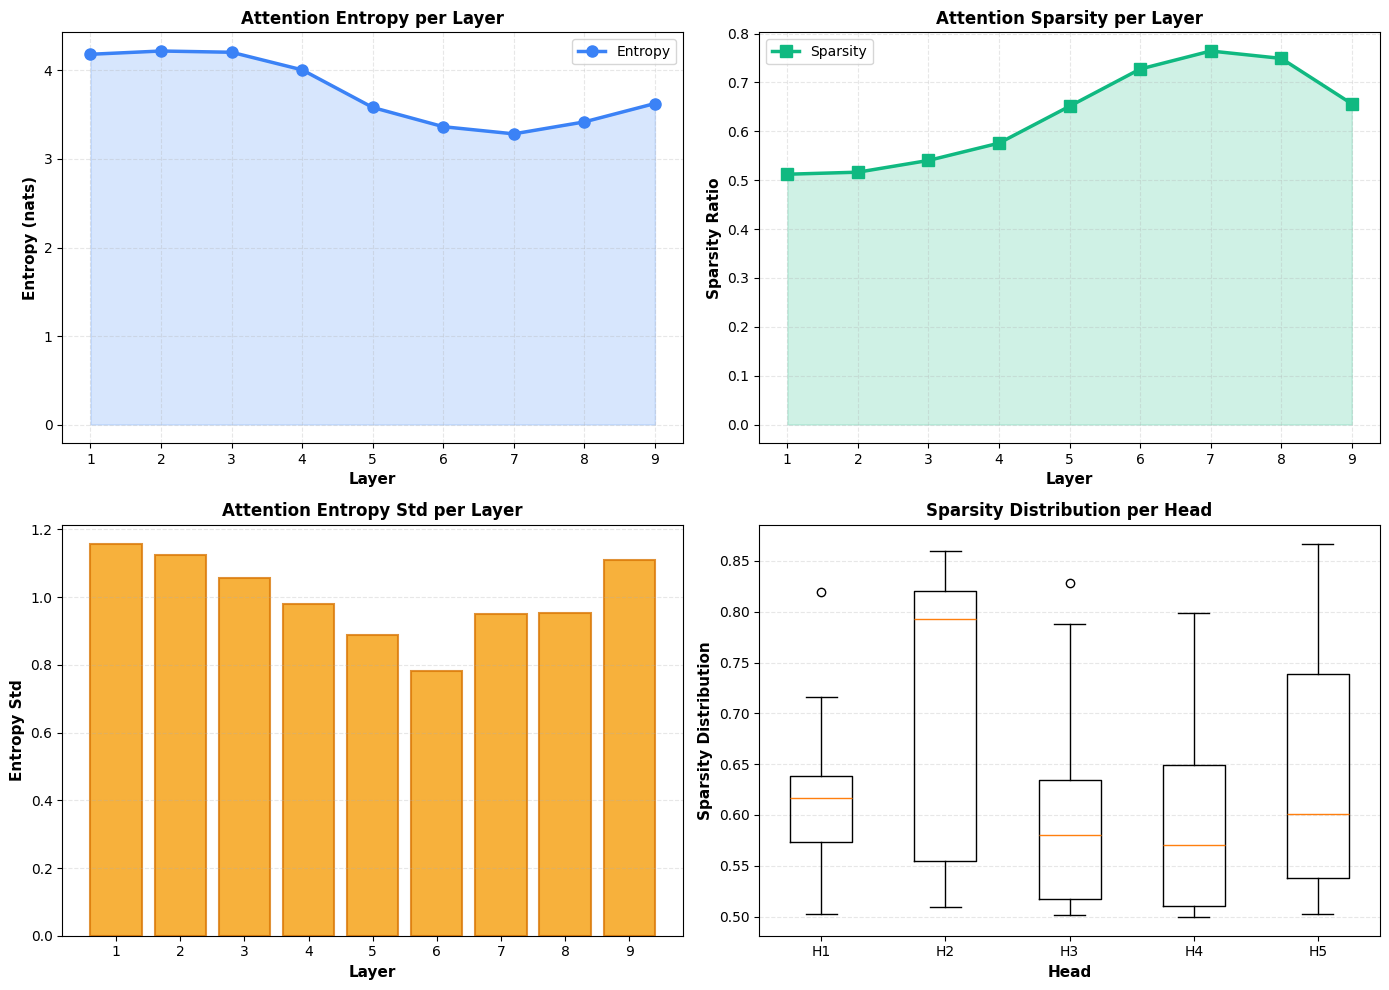


ATTENTION METRICS - PER LAYER
 Layer  Entropy Mean  Entropy Std  Sparsity
     1        4.1829       1.1559    0.5122
     2        4.2198       1.1259    0.5164
     3        4.2056       1.0566    0.5405
     4        4.0069       0.9790    0.5758
     5        3.5821       0.8886    0.6514
     6        3.3648       0.7818    0.7274
     7        3.2839       0.9495    0.7644
     8        3.4190       0.9524    0.7493
     9        3.6268       1.1084    0.6564

ATTENTION METRICS - DETAILED (Per Layer & Head)
 Layer  Head  Entropy  Entropy Std  Sparsity
     1     1 4.318395     1.081426  0.502570
     1     2 3.463883     1.356173  0.555009
     1     3 4.394255     1.000196  0.501840
     1     4 4.414500     0.995789  0.499510
     1     5 4.323454     1.013490  0.502225
     2     1 4.346425     1.059889  0.511482
     2     2 4.182660     1.226588  0.509876
     2     3 3.841249     1.190714  0.536810
     2     4 4.369166     1.020632  0.510834
     2     5 4.359725     1.02

In [13]:
# ATTENTION ANALYSIS

torch.manual_seed(SEED)
np.random.seed(SEED)

model.eval()
sample_x, _ = next(iter(train_loader))
sample_x = sample_x.to(device)

attentions = []
x = model.emb(sample_x) + model.pos(torch.arange(sample_x.size(1), device=sample_x.device))[None, :, :]
mask = torch.triu(torch.full((sample_x.size(1), sample_x.size(1)), float("-inf"), device=sample_x.device), diagonal=1)

for block in model.blocks:
    attn_in = block["ln1"](x)
    # Get attention weights (not averaged across heads)
    attn_out, attn_weights = block["attn"](
        attn_in,
        attn_in,
        attn_in,
        attn_mask=mask,
        need_weights=True,
        average_attn_weights=False
    )
    attentions.append(attn_weights.detach().cpu())
    x = x + block["drop"](attn_out)
    x = x + block["ff"](block["ln2"](x))

layers = np.arange(1, len(attentions) + 1)

entropy_layer, entropy_std_layer, sparsity_layer = [], [], [] # Calculate per-layer attention metrics

for attn in attentions:
    p = attn + 1e-9      # Add small epsilon for numerical stability
    ent = -torch.sum(p * torch.log(p), dim=-1) # Calculate entropy: -sum(p * log(p))
    entropy_layer.append(ent.mean().item())
    entropy_std_layer.append(ent.std().item())
    sparsity_layer.append((attn.abs() < 1e-3).float().mean().item())

all_metrics = []

for layer_idx, attn in enumerate(attentions):
    batch_size, num_heads, seq_len, _ = attn.shape
    for head_idx in range(num_heads):
        head_attn = attn[:, head_idx, :, :]
        p = head_attn + 1e-9
        ent = -torch.sum(p * torch.log(p), dim=-1)
        all_metrics.append({
            "Layer": layer_idx + 1,
            "Head": head_idx + 1,
            "Entropy": float(ent.mean().item()),
            "Entropy Std": float(ent.std().item()),
            "Sparsity": float((head_attn.abs() < 1e-3).float().mean().item())
        })

df_detailed = pd.DataFrame(all_metrics)

print("\n" + "="*60)
print("DEBUG - ATTENTION WEIGHTS VERIFICATION")
print("="*60)
for layer_idx, attn in enumerate(attentions[:2]):
    print(f"\nLayer {layer_idx + 1}:")
    print(f"  Shape: {attn.shape}")
    print(f"  Min: {attn.min().item():.6f}")
    print(f"  Max: {attn.max().item():.6f}")
    print(f"  Mean: {attn.mean().item():.6f}")
    print(f"  Sum per row: {attn.sum(dim=-1).mean().item():.6f}")

    seq_len = attn.shape[-1]
    uniform_value = 1.0 / seq_len
    print(f"  Uniform value: {uniform_value:.6f}")
    print(f"  Diff from uniform: {abs(attn.mean().item() - uniform_value):.6f}")




# ----- VISUALIZATION: ATTENTION METRICS CHARTS

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(layers, entropy_layer, marker="o", linewidth=2.5, markersize=8, label="Entropy", color="#3b82f6")
axes[0, 0].fill_between(layers, entropy_layer, alpha=0.2, color="#3b82f6")
axes[0, 0].set_xlabel("Layer", fontsize=11, fontweight="bold")
axes[0, 0].set_ylabel("Entropy (nats)", fontsize=11, fontweight="bold")
axes[0, 0].set_title("Attention Entropy per Layer", fontsize=12, fontweight="bold")
axes[0, 0].set_xticks(layers)
axes[0, 0].grid(alpha=0.3, linestyle="--")
axes[0, 0].legend(fontsize=10)

axes[0, 1].plot(layers, sparsity_layer, marker="s", linewidth=2.5, markersize=8, label="Sparsity", color="#10b981")
axes[0, 1].fill_between(layers, sparsity_layer, alpha=0.2, color="#10b981")
axes[0, 1].set_xlabel("Layer", fontsize=11, fontweight="bold")
axes[0, 1].set_ylabel("Sparsity Ratio", fontsize=11, fontweight="bold")
axes[0, 1].set_title("Attention Sparsity per Layer", fontsize=12, fontweight="bold")
axes[0, 1].set_xticks(layers)
axes[0, 1].grid(alpha=0.3, linestyle="--")
axes[0, 1].legend(fontsize=10)

axes[1, 0].bar(layers, entropy_std_layer, color="#f59e0b", alpha=0.8, edgecolor="#d97706", linewidth=1.5)
axes[1, 0].set_xlabel("Layer", fontsize=11, fontweight="bold")
axes[1, 0].set_ylabel("Entropy Std", fontsize=11, fontweight="bold")
axes[1, 0].set_title("Attention Entropy Std per Layer", fontsize=12, fontweight="bold")
axes[1, 0].set_xticks(layers)
axes[1, 0].grid(alpha=0.3, linestyle="--", axis="y")

head_sparsities = [df_detailed[df_detailed["Head"] == h]["Sparsity"].values for h in df_detailed["Head"].unique()]
axes[1, 1].boxplot(head_sparsities, tick_labels=[f"H{i+1}" for i in range(len(head_sparsities))])
axes[1, 1].set_xlabel("Head", fontsize=11, fontweight="bold")
axes[1, 1].set_ylabel("Sparsity Distribution", fontsize=11, fontweight="bold")
axes[1, 1].set_title("Sparsity Distribution per Head", fontsize=12, fontweight="bold")
axes[1, 1].grid(alpha=0.3, linestyle="--", axis="y")

plt.tight_layout()
plt.show()

df_metrics = pd.DataFrame({
    "Layer": layers,
    "Entropy Mean": np.round(entropy_layer, 4),
    "Entropy Std": np.round(entropy_std_layer, 4),
    "Sparsity": np.round(sparsity_layer, 4),
})

print("\n" + "="*60)
print("ATTENTION METRICS - PER LAYER")
print("="*60)
print(df_metrics.to_string(index=False))

print("\n" + "="*80)
print("ATTENTION METRICS - DETAILED (Per Layer & Head)")
print("="*80)
print(df_detailed.to_string(index=False))

print("\n" + "="*60)
print("STATISTICS PER HEAD (Average across all layers)")
print("="*60)
head_stats = df_detailed.groupby("Head")[["Entropy", "Entropy Std", "Sparsity"]].mean().round(4)
head_stats.columns = ["Avg Entropy", "Avg Entropy Std", "Avg Sparsity"]
print(head_stats)

print("\n" + "="*60)
print("STATISTICS PER LAYER (Average across all heads)")
print("="*60)
layer_stats = df_detailed.groupby("Layer")[["Entropy", "Entropy Std", "Sparsity"]].mean().round(4)
layer_stats.columns = ["Avg Entropy", "Avg Entropy Std", "Avg Sparsity"]
print(layer_stats)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Entropy mean:        {np.mean(entropy_layer):.4f}")
print(f"Entropy std:         {np.mean(entropy_std_layer):.4f}")
print(f"Sparsity mean:       {np.mean(sparsity_layer):.4f}")
print(f"Sparsity range:      {np.min(sparsity_layer):.4f} – {np.max(sparsity_layer):.4f}")
print(f"Total layers:        {len(entropy_layer)}")
print(f"Total heads/layer:   {df_detailed['Head'].max()}")
print(f"Total metrics:       {len(df_detailed)}")
print("="*60)



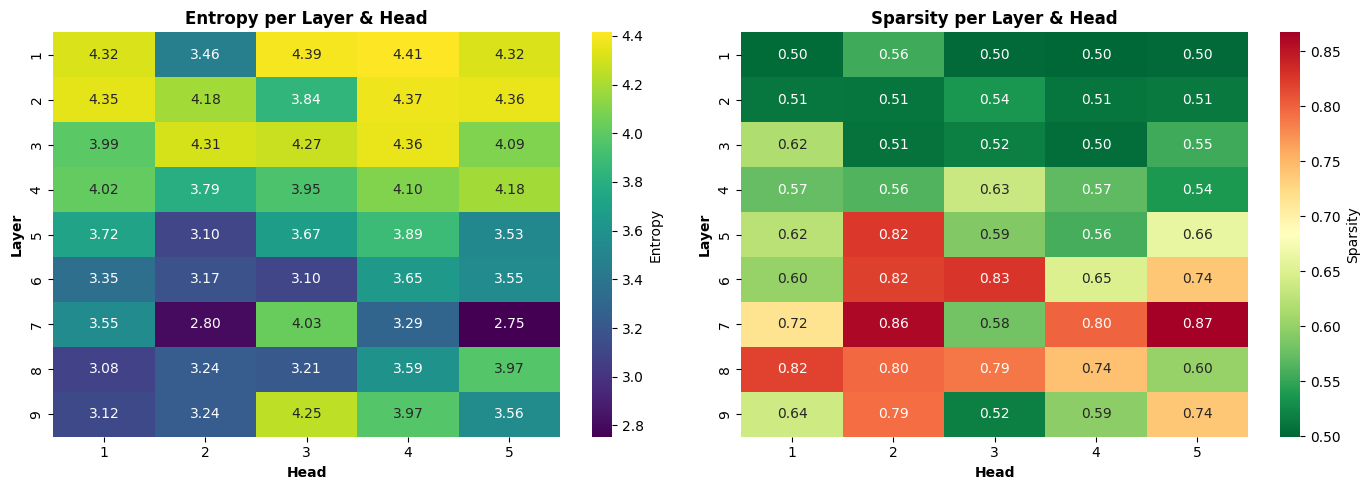

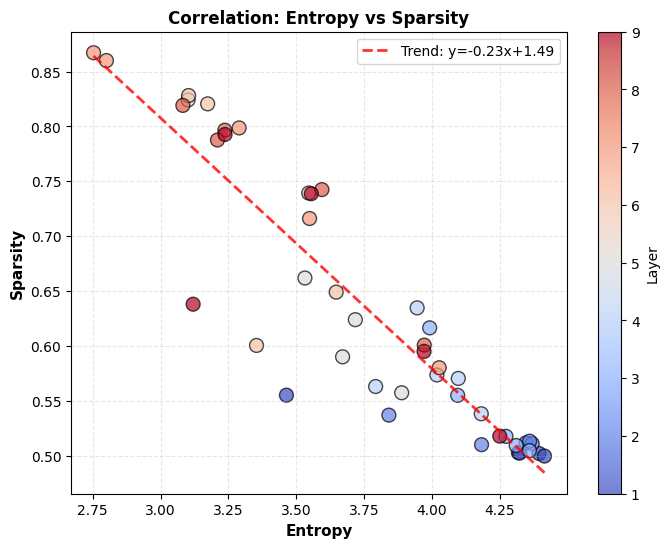


 Correlation Entropy-Sparsity: -0.9115


In [14]:
# VISUALIZATION: ATTENTION HEATMAPS

entropy_matrix = df_detailed.pivot(index='Layer', columns='Head', values='Entropy')
sparsity_matrix = df_detailed.pivot(index='Layer', columns='Head', values='Sparsity')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(entropy_matrix, annot=True, fmt='.2f', cmap='viridis',
            ax=axes[0], cbar_kws={'label': 'Entropy'})
axes[0].set_title('Entropy per Layer & Head', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Head', fontweight='bold')
axes[0].set_ylabel('Layer', fontweight='bold')

sns.heatmap(sparsity_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r',
            ax=axes[1], cbar_kws={'label': 'Sparsity'})
axes[1].set_title('Sparsity per Layer & Head', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Head', fontweight='bold')
axes[1].set_ylabel('Layer', fontweight='bold')

plt.tight_layout()
plt.show()

# VISUALIZATION: ENTROPY-SPARSITY CORRELATION
plt.figure(figsize=(8, 6))
plt.scatter(df_detailed['Entropy'], df_detailed['Sparsity'],
            c=df_detailed['Layer'], cmap='coolwarm', s=100, alpha=0.7, edgecolors='black')
plt.colorbar(label='Layer')
plt.xlabel('Entropy', fontweight='bold', fontsize=11)
plt.ylabel('Sparsity', fontweight='bold', fontsize=11)
plt.title('Correlation: Entropy vs Sparsity', fontweight='bold', fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

z = np.polyfit(df_detailed['Entropy'], df_detailed['Sparsity'], 1)
p = np.poly1d(z)
plt.plot(df_detailed['Entropy'].sort_values(),
         p(df_detailed['Entropy'].sort_values()),
         "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
plt.legend()
plt.show()

correlation = df_detailed['Entropy'].corr(df_detailed['Sparsity'])
print(f"\n Correlation Entropy-Sparsity: {correlation:.4f}")


In [15]:
# Testing and Generation

test_prompts = [
    "The movie was",
    "This product is",
    "I really enjoyed",
    "The acting was",
    "This restaurant has",
    "The quality of",
]

print("=" * 60)
print("Generation Test - Dataset Prompts")
print("=" * 60)

for prompt in test_prompts:
    output = generate(model, prompt, max_new_tokens=15, temperature=0.7, top_k=20)
    print(f"Prompt: {prompt}")
    print(f"Output: {output}\n")

Generation Test - Dataset Prompts
Prompt: The movie was
Output: The movie was too expensive to the restaurant but the _ was a lot of hard. The

Prompt: This product is
Output: This product is a part of the United States Department, and a national government in the United

Prompt: I really enjoyed
Output: I really enjoyed my dress on my phone but I didn't have any good idea, so

Prompt: The acting was
Output: The acting was designed to be the first @-@ American television series created by critics .

Prompt: This restaurant has
Output: This restaurant has been the only significant in the United States and a national anthem in the United

Prompt: The quality of
Output: The quality of the first season was the first season, and had the first season, and



In [16]:
end_time = time.time()
elapsed = end_time - start_time

print(f"Total execution time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

Total execution time: 3965.3 seconds (66.1 minutes)
